In [38]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

In [39]:
training_points = multivariate_normal.rvs(size=(10,2))

# df = pd.DataFrame(training_points)
# df.to_csv('training_points_causing_problem.csv')

# df = pd.read_csv("training_points_causing_problem.csv") 
# training_points = df.values[:,1:]

In [40]:
training_points

array([[-0.3426437 , -0.04986056],
       [ 0.52872104,  1.82957496],
       [ 0.13654072,  0.62220881],
       [-2.32450216, -0.28168664],
       [-1.07851104, -0.25161946],
       [ 0.18636231,  2.06290861],
       [ 0.6815146 , -0.7437402 ],
       [ 1.48500079,  0.85851362],
       [-1.7190376 , -0.04761177],
       [ 0.2247663 ,  1.385044  ]])

In [85]:

class RarePatternDetect:
    def __init__(self, training_set: np.array, min_area: float):
        self.training_set = training_set # a N x d matrix
        self.min_area = min_area # the smallest allowed area
        self.N, self.d = self.training_set.shape
        self.Nrange, self.drange = (range(x) for x in self.training_set.shape)
        self.largest_bounding_area = np.array([
            [
                np.min(self.training_set[:,0]),
                np.min(self.training_set[:,1])
            ], 
            [
                np.max(self.training_set[:,0]),
                np.max(self.training_set[:,1])
            ]])
        self.model = self.create_model()
           
    
    def create_model(self):
        def _pattern_area():
            return pyo.prod(model.interval_lengths[i] for i in self.drange)

        # define model
        model = pyo.ConcreteModel()

        ## variables

        # x is a 2d vector
        model.d_dimension = pyo.Set(initialize=self.drange) 
        model.matrix = pyo.Set(initialize=model.d_dimension * range(2)) 
        
        # TODO: simplify with np.apply_along_axis
        def _adjust_pattern_bounds(model, i, j): 
            #print("i,j: ",i,j)
            if (i,j) == (0,0):
                min_b = np.min(self.training_set[:,i])
                max_b = np.max(self.training_set[:,i])
            elif (i,j) == (0,1):
                min_b = np.min(self.training_set[:,i])
                max_b = np.max(self.training_set[:,i])
            elif (i,j) == (1,0):
                min_b = np.min(self.training_set[:,j])
                max_b = np.max(self.training_set[:,j])
            else: # (1,1)
                min_b = np.min(self.training_set[:,j])
                max_b = np.max(self.training_set[:,j])
            return (min_b, max_b)

        model.pattern = pyo.Var(model.matrix , bounds=_adjust_pattern_bounds)

        # y is a boolean vector of size N
        model.included = pyo.Var(self.Nrange, within=pyo.Binary, initialize=0)

        # auxiliary variables
        model.interval_lengths = pyo.Var(self.drange, within=pyo.NonNegativeReals)
        model.point_left_of_pattern = pyo.Var(self.Nrange, self.drange, within=pyo.Binary, initialize=0)
        model.point_right_of_pattern = pyo.Var(self.Nrange, self.drange, within=pyo.Binary, initialize=0)
        
        ## objective (minimised by default)
        model.obj = pyo.Objective(expr= sum(model.included[i] for i in self.Nrange) / _pattern_area(), sense=pyo.minimize)

        ## constraints

        # pattern area needs to exceed min_area
        model.area_constraint = pyo.Constraint(expr= _pattern_area() >= self.min_area)

        # training points included in model.included lie within the pattern (NB: In principle we would need to ensure that points not included are also
        # not included in model.included. However, since including points outside the pattern increases the objective, this is covered.)

        model.include_constraint = pyo.ConstraintList()
        model.enforce_point_left_of_pattern = pyo.ConstraintList()
        model.enforce_point_right_of_pattern = pyo.ConstraintList()
        M = 100000
        for j in self.Nrange:
            for i in self.drange:
                # enforcing auxiliary variables are correct: point_left_of_pattern[j,i] is True iff the jth training point lies strictly outside the pattern in ith dimension, etc.
                model.enforce_point_left_of_pattern.add(
                    (model.point_left_of_pattern[j, i]*M + self.training_set[j,i]) >=  model.pattern[0,i]
                )
                model.enforce_point_left_of_pattern.add(
                     self.training_set[j,i] + 1e-3 <=  (model.pattern[0,i] + (1-model.point_left_of_pattern[j, i])*M)
                )
                model.enforce_point_right_of_pattern.add(
                   self.training_set[j,i] <=  (model.pattern[1,i] + model.point_right_of_pattern[j, i]*M)
                )
                model.enforce_point_right_of_pattern.add(
                    ((1-model.point_right_of_pattern[j, i])*M + self.training_set[j,i]) >=  (model.pattern[1,i] + 1e-3)
                )

            model.include_constraint.add(
                # key bit: this constraint enforces that the model.included for jth point can be set to 0 only if the point is not contained in the pattern (as witnessed by the fact
                # that the corresponding auxiliary variables are all 0)
                model.included[j] + sum(model.point_right_of_pattern[j,i] + model.point_left_of_pattern[j,i] for i in self.drange)  >= 1
            )

        # connect auxiliary variables: interval lengths are differences of pattern points
        model.interval_constraint = pyo.ConstraintList()
        for i in self.drange:
            model.interval_constraint.add(
                model.interval_lengths[i] == model.pattern[1,i] - model.pattern[0,i]
            )
        print("model.interval_lengths: ", model.interval_lengths)
        return model

    def add_point_to_model(self, point):
        # point to be classified lies in pattern
        point = point.squeeze()
        assert point.shape == (2,)
        self.model.point_constraint = pyo.ConstraintList()
        for i in self.drange:
            # x[i] <= point[i] <= x[i + d], for all i
            self.model.point_constraint.add(self.model.pattern[0, i] <= point[i])
            self.model.point_constraint.add(point[i] <= self.model.pattern[1, i])

    def extract_points_included_in_pattern(self):
        included_points = []
        for i in self.model.included:
            if np.round(self.model.included[i].value,1) == 1.0:
                # print("included point index: ",i, self.training_set[i])
                included_points.append(self.training_set[i])
        return np.array(included_points)

    def extract_pattern(self):
        intervals = np.zeros((2,2), dtype=float)
        for _, j in enumerate(self.model.pattern):
            # print("pattern coordinate value: ", j, self.model.pattern[j].value)
            intervals[j] = self.model.pattern[j].value
        return intervals.T

    def classify(self, point_to_be_classified: np.array):
        self.add_point_to_model(point_to_be_classified) # point to be classified is a 1 x d array
        _ = pyo.SolverFactory('mindtpy').solve(self.model, strategy='OA', mip_solver='glpk', nlp_solver='ipopt', tee=True,)
        self.model.display()
        return pyo.value(self.model.obj)

In [86]:
training_points_test = np.array([
            [0.0, 0.0],
            [2.0, 0.0],
            [0.0, 2.0],
            [2.0, 2.0],
            [1.0, 1.0]]
        )

In [87]:
training_points, training_points_test

(array([[-0.3426437 , -0.04986056],
        [ 0.52872104,  1.82957496],
        [ 0.13654072,  0.62220881],
        [-2.32450216, -0.28168664],
        [-1.07851104, -0.25161946],
        [ 0.18636231,  2.06290861],
        [ 0.6815146 , -0.7437402 ],
        [ 1.48500079,  0.85851362],
        [-1.7190376 , -0.04761177],
        [ 0.2247663 ,  1.385044  ]]),
 array([[0., 0.],
        [2., 0.],
        [0., 2.],
        [2., 2.],
        [1., 1.]]))

In [89]:
rare_pattern_detect = RarePatternDetect(training_points_test, min_area=0.1)
point_to_be_classified = training_points_test[1]
print("point_to_be_classified: ", point_to_be_classified[0])
results = rare_pattern_detect.classify(point_to_be_classified)
intervals = rare_pattern_detect.extract_pattern()
included_points = rare_pattern_detect.extract_points_included_in_pattern()

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 52 constraints (1 nonlinear) and 0 disjunctions, with 31 variables, of which 25 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



Nrange:  0
Nrange:  1
Nrange:  2
Nrange:  3
Nrange:  4
drange:  0
drange:  1
model.interval_lengths:  interval_lengths
point_to_be_classified:  2.0


         -       Relaxed NLP      -1.03241e-08            inf   -1.03241e-08      nan%      0.30
         1              MILP      -4.02445e-09            inf   -4.02445e-09      nan%      0.34
NLP subproblem was locally infeasible.
Solving feasibility problem
Feasibility subproblem infeasible. This should never happen.
 Primal integral          :       nan 
 Dual integral            :    0.0000 
 Primal-dual gap integral :       nan 


Model unknown

  Variables:
    pattern : Size=4, Index=matrix
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :   0.0 :  None :   2.0 : False :  True :  Reals
        (0, 1) :   0.0 :  None :   2.0 : False :  True :  Reals
        (1, 0) :   0.0 :  None :   2.0 : False :  True :  Reals
        (1, 1) :   0.0 :  None :   2.0 : False :  True :  Reals
    included : Size=5, Index=included_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :     0 :     1 : False :  True : Binary
          1 :     0 :     0 :     1 : False :  True : Binary
          2 :     0 :     0 :     1 : False :  True : Binary
          3 :     0 :     0 :     1 : False :  True : Binary
          4 :     0 :     0 :     1 : False :  True : Binary
    interval_lengths : Size=2, Index=interval_lengths_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :  None : False :  True : NonNegativeReals
          1 :  

ValueError: No value for uninitialized NumericValue object interval_lengths[0]

In [64]:
rare_pattern_detect.model.display()

Model unknown

  Variables:
    pattern : Size=4, Index=matrix
        Key    : Lower               : Value               : Upper              : Fixed : Stale : Domain
        (0, 0) : -2.3245021594650894 : 0.22576629457225597 : 1.4850007929946243 : False : False :  Reals
        (0, 1) : -2.3245021594650894 : -0.7427401791688111 : 1.4850007929946243 : False : False :  Reals
        (1, 0) : -2.3245021594650894 :   1.484000802026023 : 1.4850007929946243 : False : False :  Reals
        (1, 1) :  -0.743740198011568 :  2.0629086126889247 : 2.0629086126834295 : False : False :  Reals
    included : Size=10, Index=included_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :     1 : False : False : Binary
          1 :     0 :   1.0 :     1 : False : False : Binary
          2 :     0 :   0.0 :     1 : False : False : Binary
          3 :     0 :   0.0 :     1 : False : False : Binary
          4 :     0 :   0.0 :     1 : False : False : Binary
 

In [46]:
from io import StringIO 

textbuffer = StringIO()
for v in rare_pattern_detect.model.component_objects(pyo.Var):
    v.pprint(textbuffer)
    textbuffer.write('\n')

for v in rare_pattern_detect.model.component_objects(pyo.Constraint):
    v.pprint(textbuffer)
    textbuffer.write('\n')

for v in rare_pattern_detect.model.component_objects(pyo.Set):
    v.pprint(textbuffer)
    textbuffer.write('\n')


with open('solver_log_2.txt', 'w') as outputfile:
    outputfile.write(textbuffer.getvalue())

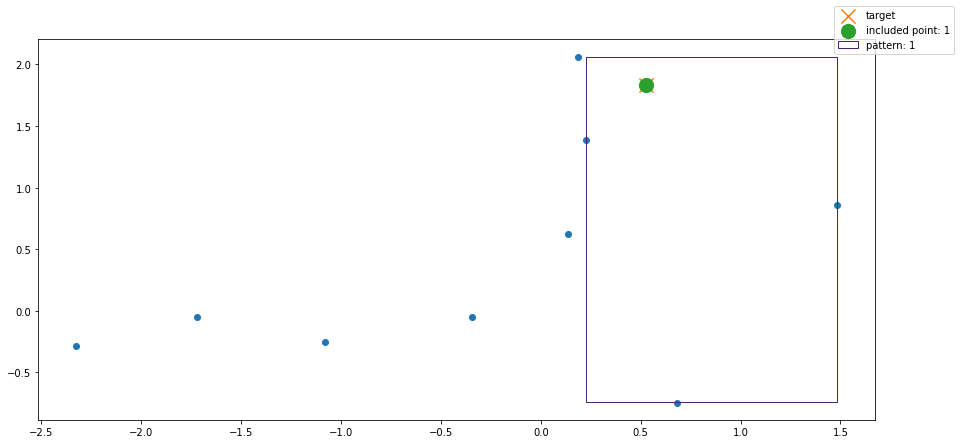

In [47]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

cmap = plt.get_cmap('viridis')

def draw2dpattern(interval, ax, index, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(index/total),
        label=f"pattern: {index}"
        )
    )


plt.scatter(x=training_points[:,0], y=training_points[:,1])
plt.scatter(x=point_to_be_classified[0], y=point_to_be_classified[1], marker="x",  s=200, label="target") 
for i, p in enumerate(included_points):
    plt.scatter(x=p[0], y=p[1], marker="o", s=200, label=f"included point: {np.argwhere(training_points == p)[0,0]}")
ax = plt.gca()
draw2dpattern(intervals, ax, 1, len(training_points))
ax.legend(bbox_to_anchor=(1.1, 1.1))
plt.show()

In [48]:
# min x , min y 
# max x , max y
rare_pattern_detect.largest_bounding_area

array([[-2.32450216, -0.7437402 ],
       [ 1.48500079,  2.06290861]])

In [49]:
from typing import Callable
import numpy as np
import json

class PACRPAD:
    """
    Superclass for all PAC-RPAD implementations
    """
    def __init__(self, tau, epsilon, delta):
        self.tau = tau
        self.epsilon = epsilon
        self.delta = delta
        self.find_min_f_hat = None

    def has_rare_pattern(self, point) -> bool:
        results = self.find_min_f_hat[f"{point}"]
        if results['objective'] != None:
            results['anomaly'] = results['objective'] <= self.tau + self.epsilon / 2
        return results['anomaly']


class AxisAlignedHyperRectanglePACRPAD(PACRPAD):
    def __init__(self, tau, epsilon, delta):
        super().__init__(tau, epsilon, delta)
        self.solver = None 
        self.training_points = None
        self.testing_points = None

    def construct_f_hat_estimator(self, training_points, testing_points, min_area=0.01):
        def _contains(point: np.ndarray, largest_bounding_area) -> bool:
            return all((largest_bounding_area[0,:] <= point.T) & (point.T <= largest_bounding_area[1,:]))

        self.training_points = training_points
        self.testing_points = testing_points
        dict_results = {}

        # Check if testing points lie within the initial pattern bounds
        dummy_solver = RarePatternDetect(self.training_points, min_area=min_area)
        candidates = []
        for idx, test_p in enumerate(self.testing_points):
            # TODO: extract the largest_bounding_area outside of the solver 
            # TODO: extract the functionalities of evaluating to has rare pattern 
            contained = _contains(test_p, dummy_solver.largest_bounding_area)
            if contained:
                # if yes then add testing_points to ensemble of points used to create the pattern space 
                candidates = [train_p for train_p in self.training_points]
                candidates = np.array(candidates)
                candidates = np.append(candidates, [test_p], axis=0)
                self.solver = RarePatternDetect(candidates, min_area=min_area)
                objective = self.solver.classify(test_p)
                intervals = self.solver.extract_pattern()
                included_points = self.solver.extract_points_included_in_pattern()
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : None,
                    'objective' : objective, 
                    'pattern' : intervals.tolist(), 
                    'included points' : included_points.tolist()
                }
            else:
                # else: anomaly = True
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : True,
                    'objective' : None, 
                    'pattern' : None, 
                    'included points' : None
                }

        with open('minlp_results.json', 'w') as fp:
            json.dump(dict_results, fp, indent=4)

        self.find_min_f_hat = dict_results

In [50]:
exact = AxisAlignedHyperRectanglePACRPAD(tau=0.3, epsilon=0.1, delta=0.1)

In [51]:
testing_points = multivariate_normal.rvs(size=(20,2))
testing_points

array([[-1.42816895, -1.23015029],
       [ 1.69003955,  0.06532332],
       [-0.24295228,  0.36421006],
       [ 0.37963298,  0.28249354],
       [-1.446652  ,  0.84924253],
       [-2.12534552, -1.50513691],
       [-0.43135782,  1.315257  ],
       [-1.15340541,  1.27604264],
       [ 1.19561994,  0.69010565],
       [ 1.75983904, -0.1089035 ],
       [ 0.2086718 , -0.30245236],
       [ 1.50863353, -0.42207456],
       [-0.90623757,  0.67170902],
       [ 0.38363559, -0.29558723],
       [ 0.8326871 , -1.46287898],
       [ 0.71358532,  1.47902071],
       [-1.31910037,  0.02073572],
       [-1.52814236, -2.27956044],
       [ 0.91089824, -0.48316881],
       [ 0.02166684, -0.26348202]])

In [52]:
exact.construct_f_hat_estimator(training_points, testing_points, min_area=0)
labels_pac_minlp = [exact.has_rare_pattern(x) for x in exact.testing_points]
labels_pac_minlp

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 106 constraints (1 nonlinear) and 0 disjunctions, with 61 variables, of which 55 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



model.interval_lengths:  interval_lengths
model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.13718e-08            inf    1.13718e-08      nan%      0.29
         1              MILP         0.0786858            inf      0.0786858      nan%      0.36
*        1         Fixed NLP          0.393175       0.393175      0.0786858    79.99%      0.51
         2              MILP         0.0786858       0.393175      0.0786858    79.99%      0.54
*        2         Fixed NLP          0.255472       0.255472      0.0786858    69.20%      0.66
         3              MILP          0.169879       0.255472       0.169879    33.50%      0.70
         3         Fixed NLP          0.477645       0.255472       0.169879    33.50%      0.79
         4              MILP          0.172157       0.255472       0.172157    32.61%      0.83
*        4         Fixed NLP          0.192696       0.192696       0.172157    10.66%      0.96
         5              MILP          0.192696       0.192696       0.192696     0.00%      1.02
MindtPy exiting on bound conve

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.17428e-08            inf    1.17428e-08      nan%      0.21
         1              MILP         0.0752817            inf      0.0752817      nan%      0.26
*        1         Fixed NLP           1.56991        1.56991      0.0752817    95.20%      0.38
         2              MILP         0.0752817        1.56991      0.0752817    95.20%      0.41
*        2         Fixed NLP          0.754831       0.754831      0.0752817    90.03%      0.52
         3              MILP         0.0752817       0.754831      0.0752817    90.03%      0.56
*        3         Fixed NLP          0.401373       0.401373      0.0752817    81.24%      0.66
         4              MILP          0.112675       0.401373       0.112675    71.93%      0.71
*        4         Fixed NLP          0.332117       0.332117       0.112675    66.07%      0.80
         5              MILP          0.170526       0.332117       0.170526    48.65%      0.83
         5         Fixed NLP  

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.17431e-08            inf    1.17431e-08      nan%      0.15
         1              MILP         0.0749679            inf      0.0749679      nan%      0.19
*        1         Fixed NLP          0.345108       0.345108      0.0749679    78.28%      0.48
         2              MILP         0.0749679       0.345108      0.0749679    78.28%      0.52
*        2         Fixed NLP          0.239311       0.239311      0.0749679    68.67%      0.63
         3              MILP          0.143069       0.239311       0.143069    40.22%      0.66
         3         Fixed NLP          0.356954       0.239311       0.143069    40.22%      0.75
         4              MILP           0.18142       0.239311        0.18142    24.19%      0.79
*        4         Fixed NLP          0.192696       0.192696        0.18142     5.85%      0.90
         5              MILP          0.192696       0.192696       0.192696     0.00%      0.94
MindtPy exiting on bound conve

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.17905e-08            inf    1.17905e-08      nan%      0.18
         1              MILP         0.0748811            inf      0.0748811      nan%      0.22
*        1         Fixed NLP          0.743984       0.743984      0.0748811    89.94%      0.33
         2              MILP         0.0748811       0.743984      0.0748811    89.94%      0.36
*        2         Fixed NLP          0.216777       0.216777      0.0748811    65.46%      0.47
         3              MILP         0.0784658       0.216777      0.0784658    63.80%      0.51
         3         Fixed NLP           0.31058       0.216777      0.0784658    63.80%      0.60
         4              MILP          0.189687       0.216777       0.189687    12.50%      0.63
*        4         Fixed NLP          0.192696       0.192696       0.189687     1.56%      0.74
         5              MILP          0.192696       0.192696       0.192696     0.00%      0.78
MindtPy exiting on bound conve

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.16883e-08            inf    1.16883e-08      nan%      0.15
         1              MILP          0.074466            inf       0.074466      nan%      0.18
*        1         Fixed NLP          0.500582       0.500582       0.074466    85.12%      0.30
         2              MILP          0.074466       0.500582       0.074466    85.12%      0.33
*        2         Fixed NLP          0.326496       0.326496       0.074466    77.19%      0.43
         3              MILP          0.074466       0.326496       0.074466    77.19%      0.47
         3         Fixed NLP          0.357036       0.326496       0.074466    77.19%      0.55
         4              MILP         0.0913571       0.326496      0.0913571    72.02%      0.59
*        4         Fixed NLP          0.192696       0.192696      0.0913571    52.59%      0.70
         5              MILP          0.192696       0.192696       0.192696     0.00%      0.74
MindtPy exiting on bound conve

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.18741e-08            inf    1.18741e-08      nan%      0.15
         1              MILP         0.0743197            inf      0.0743197      nan%      0.19
*        1         Fixed NLP           1.04459        1.04459      0.0743197    92.89%      0.30
         2              MILP         0.0743197        1.04459      0.0743197    92.89%      0.33
*        2         Fixed NLP          0.591453       0.591453      0.0743197    87.43%      0.44
         3              MILP         0.0743197       0.591453      0.0743197    87.43%      0.47
*        3         Fixed NLP          0.284378       0.284378      0.0743197    73.87%      0.59
         4              MILP         0.0743197       0.284378      0.0743197    73.87%      0.68
         4         Fixed NLP          0.410471       0.284378      0.0743197    73.87%      0.77
         5              MILP           0.23754       0.284378        0.23754    16.47%      0.81
         5         Fixed NLP  

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.17824e-08            inf    1.17824e-08      nan%      0.14
         1              MILP         0.0749159            inf      0.0749159      nan%      0.17
*        1         Fixed NLP          0.570589       0.570589      0.0749159    86.87%      0.30
         2              MILP         0.0749159       0.570589      0.0749159    86.87%      0.33
         2         Fixed NLP           0.86596       0.570589      0.0749159    86.87%      0.45
         3              MILP         0.0749159       0.570589      0.0749159    86.87%      0.49
*        3         Fixed NLP          0.463762       0.463762      0.0749159    83.85%      0.62
         4              MILP         0.0749159       0.463762      0.0749159    83.85%      0.65
*        4         Fixed NLP          0.160669       0.160669      0.0749159    53.37%      0.75
         5              MILP          0.160669       0.160669       0.160669     0.00%      0.79
MindtPy exiting on bound conve

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.18639e-08            inf    1.18639e-08      nan%      0.14
         1              MILP         0.0753757            inf      0.0753757      nan%      0.18
*        1         Fixed NLP           1.49688        1.49688      0.0753757    94.96%      0.28
         2              MILP         0.0753757        1.49688      0.0753757    94.96%      0.31
*        2         Fixed NLP          0.314631       0.314631      0.0753757    76.04%      0.45
         3              MILP         0.0753757       0.314631      0.0753757    76.04%      0.48
         3         Fixed NLP          0.345199       0.314631      0.0753757    76.04%      0.74
         4              MILP         0.0937207       0.314631      0.0937207    70.21%      0.78
*        4         Fixed NLP          0.192696       0.192696      0.0937207    51.36%      0.90
         5              MILP          0.178964       0.192696       0.178964     7.13%      0.94
         5         Fixed NLP  

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.16176e-08            inf    1.16176e-08      nan%      0.14
         1              MILP         0.0764552            inf      0.0764552      nan%      0.18
*        1         Fixed NLP          0.171712       0.171712      0.0764552    55.47%      0.29
         2              MILP          0.127986       0.171712       0.127986    25.46%      0.33
         2         Fixed NLP          0.754831       0.171712       0.127986    25.46%      0.42
         3              MILP          0.160045       0.171712       0.160045     6.79%      0.46
*        3         Fixed NLP          0.160669       0.160669       0.160045     0.39%      0.56
         4              MILP          0.160669       0.160669       0.160669     0.00%      0.60
MindtPy exiting on bound convergence. |Primal Bound: 0.16066914586287542 - Dual Bound: 0.160669145953781| <= (absolute tolerance 0.0001)  

 Primal integral          :    0.0046 
 Dual integral            :    0.0309 
 Prima

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.18902e-08            inf    1.18902e-08      nan%      0.18
         1              MILP         0.0739584            inf      0.0739584      nan%      0.22
*        1         Fixed NLP          0.820138       0.820138      0.0739584    90.98%      0.32
         2              MILP         0.0739584       0.820138      0.0739584    90.98%      0.35
*        2         Fixed NLP          0.593338       0.593338      0.0739584    87.54%      0.46
         3              MILP         0.0739584       0.593338      0.0739584    87.54%      0.50
*        3         Fixed NLP          0.423832       0.423832      0.0739584    82.55%      0.60
         4              MILP         0.0739584       0.423832      0.0739584    82.55%      0.63
*        4         Fixed NLP          0.300424       0.300424      0.0739584    75.38%      0.73
         5              MILP           0.16388       0.300424        0.16388    45.45%      0.77
         5         Fixed NLP  

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.18736e-08            inf    1.18736e-08      nan%      0.16
         1              MILP         0.0752881            inf      0.0752881      nan%      0.20
*        1         Fixed NLP          0.393175       0.393175      0.0752881    80.85%      0.32
         2              MILP         0.0752881       0.393175      0.0752881    80.85%      0.35
         2         Fixed NLP          0.741608       0.393175      0.0752881    80.85%      0.44
         3              MILP         0.0752881       0.393175      0.0752881    80.85%      0.48
*        3         Fixed NLP          0.356954       0.356954      0.0752881    78.91%      0.59
         4              MILP         0.0752881       0.356954      0.0752881    78.91%      0.62
*        4         Fixed NLP          0.255744       0.255744      0.0752881    70.56%      0.73
         5              MILP          0.172068       0.255744       0.172068    32.72%      0.77
*        5         Fixed NLP  

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.19268e-08            inf    1.19268e-08      nan%      0.15
         1              MILP         0.0746304            inf      0.0746304      nan%      0.19
*        1         Fixed NLP          0.485231       0.485231      0.0746304    84.62%      0.29
         2              MILP         0.0746304       0.485231      0.0746304    84.62%      0.32
         2         Fixed NLP          0.570739       0.485231      0.0746304    84.62%      0.45
         3              MILP          0.092427       0.485231       0.092427    80.95%      0.49
*        3         Fixed NLP          0.401373       0.401373       0.092427    76.97%      0.60
         4              MILP          0.142517       0.401373       0.142517    64.49%      0.64
*        4         Fixed NLP          0.284378       0.284378       0.142517    49.88%      0.75
         5              MILP          0.158942       0.284378       0.158942    44.11%      0.78
*        5         Fixed NLP  

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.18678e-08            inf    1.18678e-08      nan%      0.14
         1              MILP         0.0741362            inf      0.0741362      nan%      0.17
*        1         Fixed NLP            19.505         19.505      0.0741362    99.62%      0.29
         2              MILP         0.0741362         19.505      0.0741362    99.62%      0.32
*        2         Fixed NLP          0.160669       0.160669      0.0741362    53.86%      0.45
         3              MILP          0.116253       0.160669       0.116253    27.64%      0.48
         3         Fixed NLP          0.477645       0.160669       0.116253    27.64%      0.57
         4              MILP          0.160669       0.160669       0.160669     0.00%      0.61
MindtPy exiting on bound convergence. |Primal Bound: 0.16066914586284858 - Dual Bound: 0.160669145953781| <= (absolute tolerance 0.0001)  

 Primal integral          :    5.1797 
 Dual integral            :    0.0450 
 Prima

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

pattern:  None


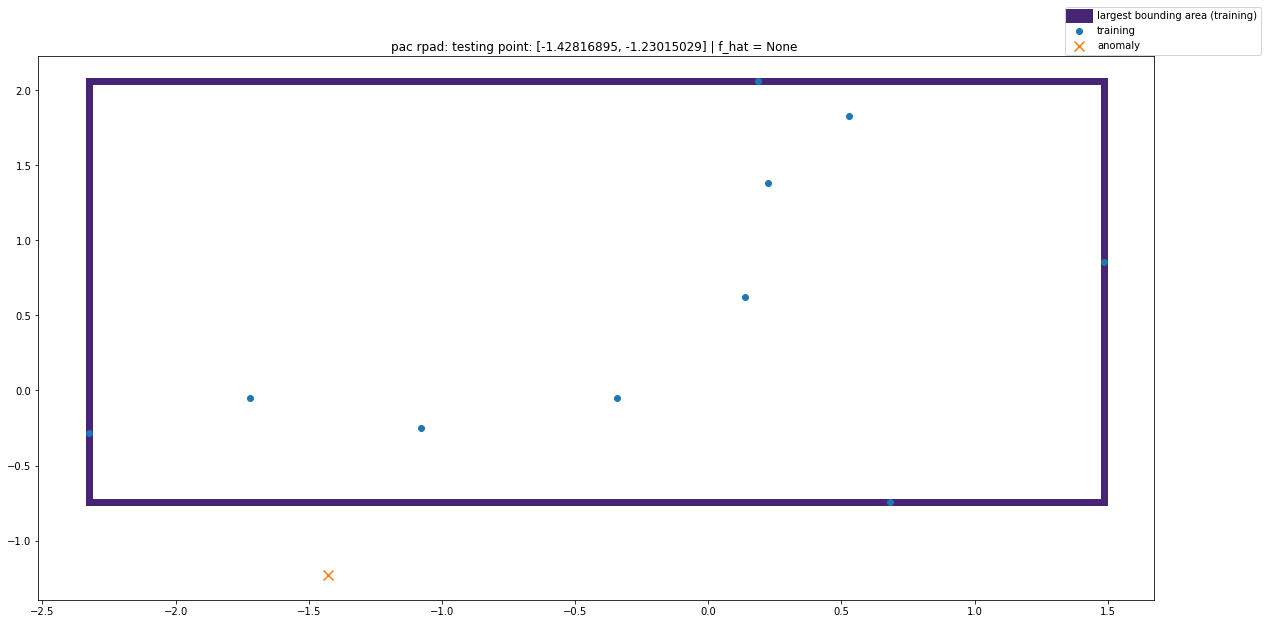

pattern:  None


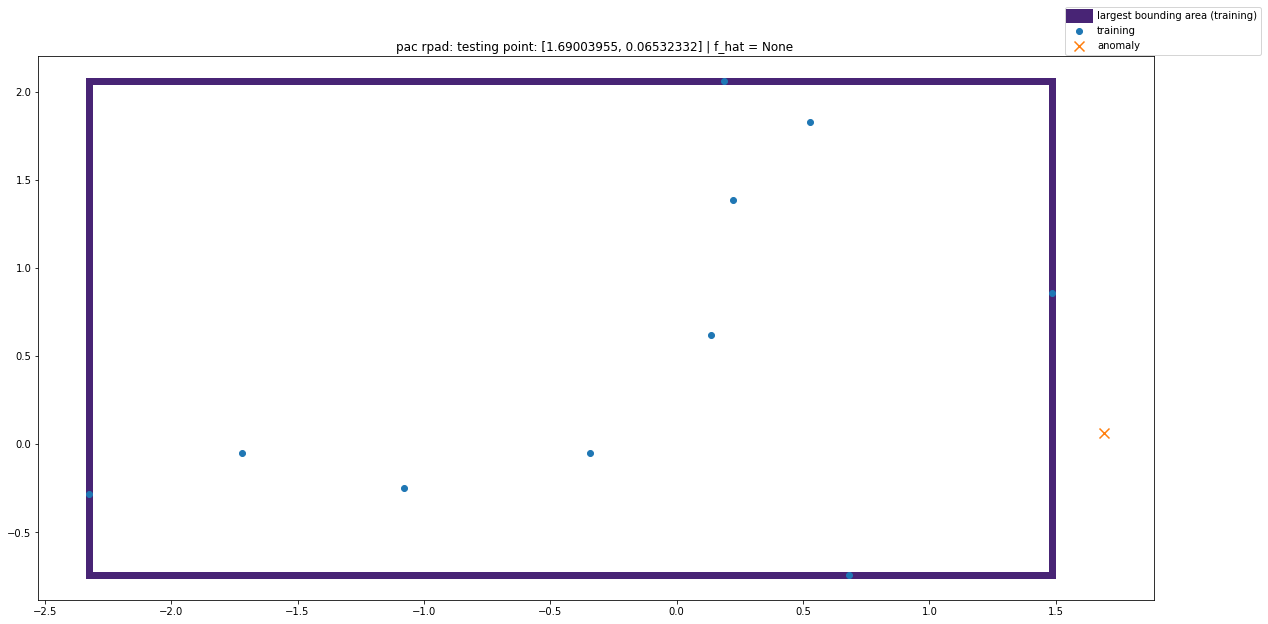

pattern:  [[-2.32450216  0.1355407 ]
 [-0.04661175  2.06290861]]


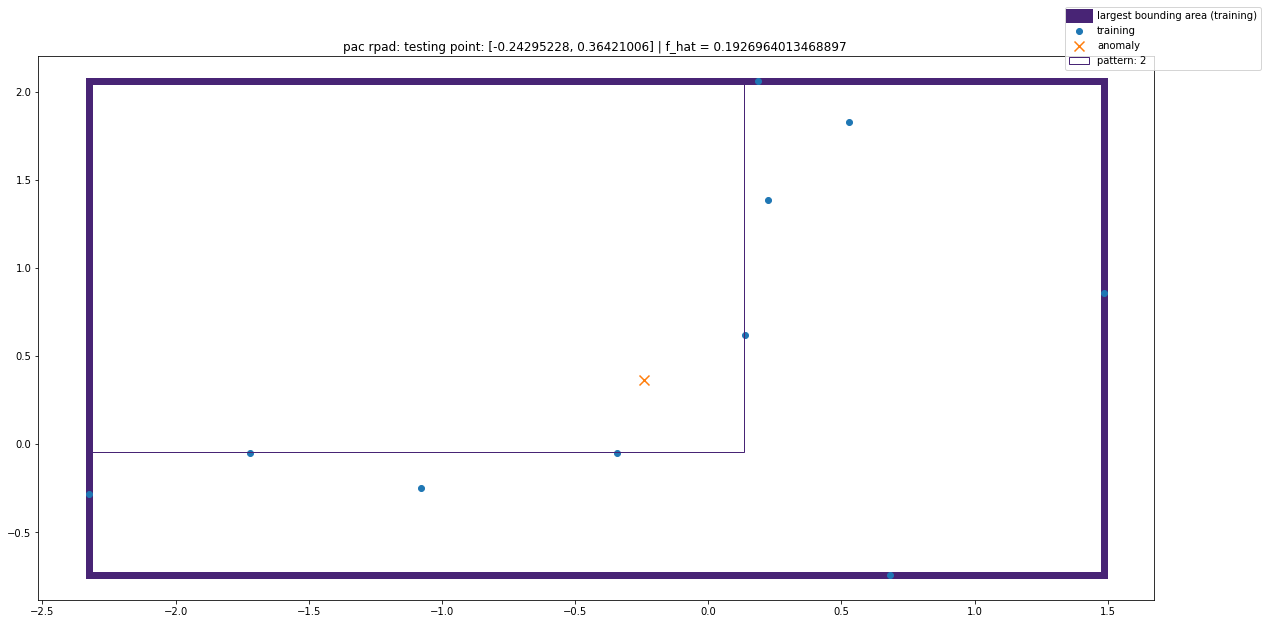

pattern:  [[ 0.2257663   1.48400079]
 [-0.74274019  1.82857495]]


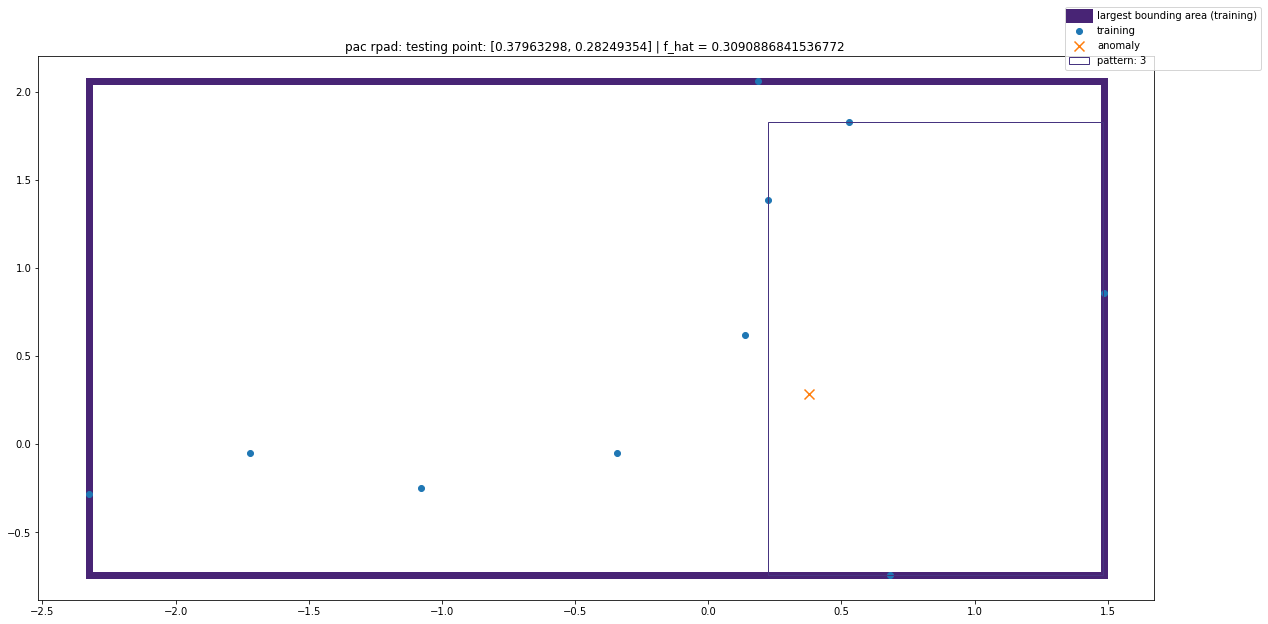

pattern:  [[-2.32450216  0.1355407 ]
 [-0.04661175  2.06290861]]


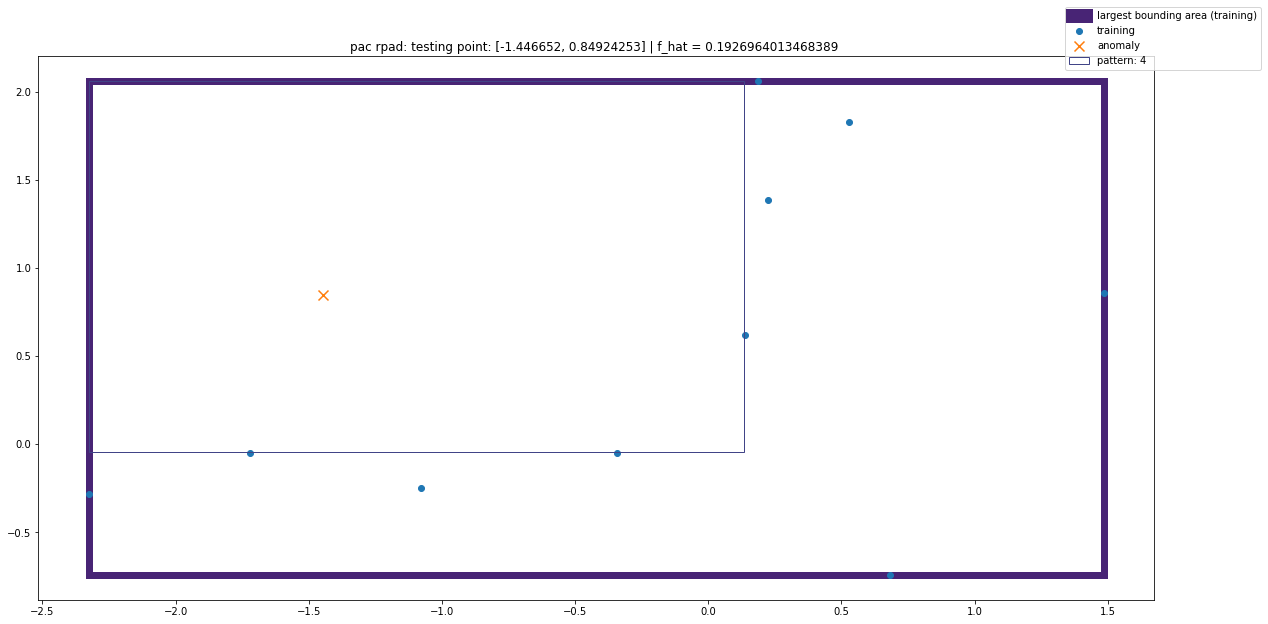

pattern:  None


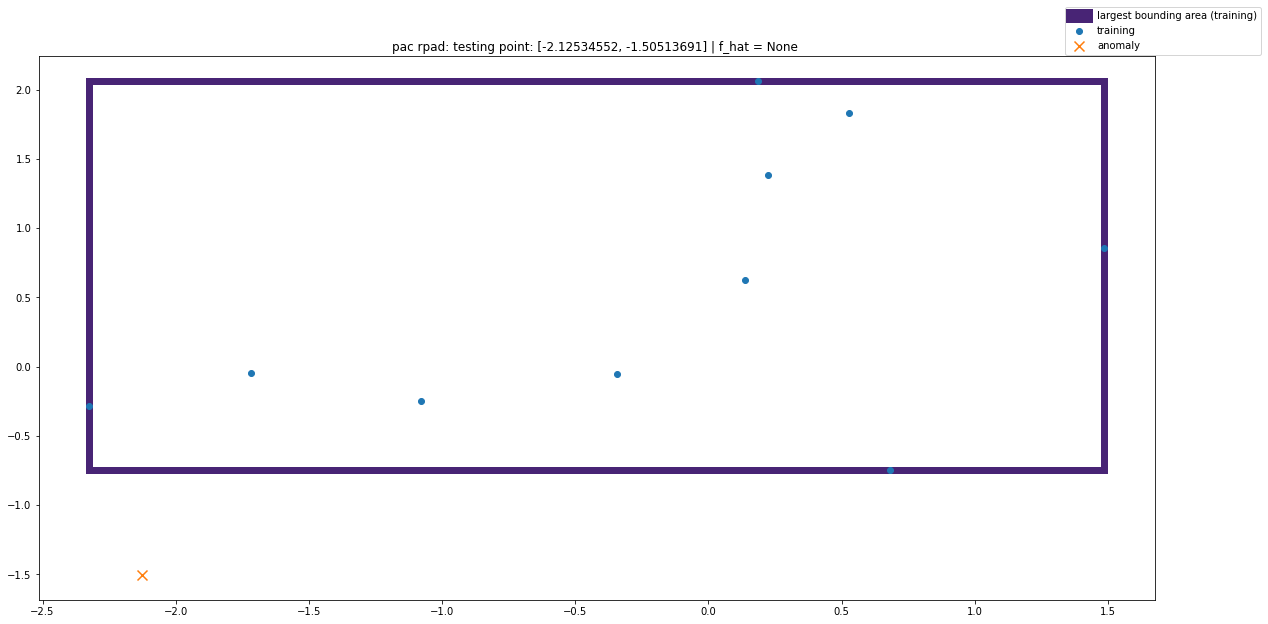

pattern:  [[-2.32450216  0.1355407 ]
 [-0.04661175  2.06290861]]


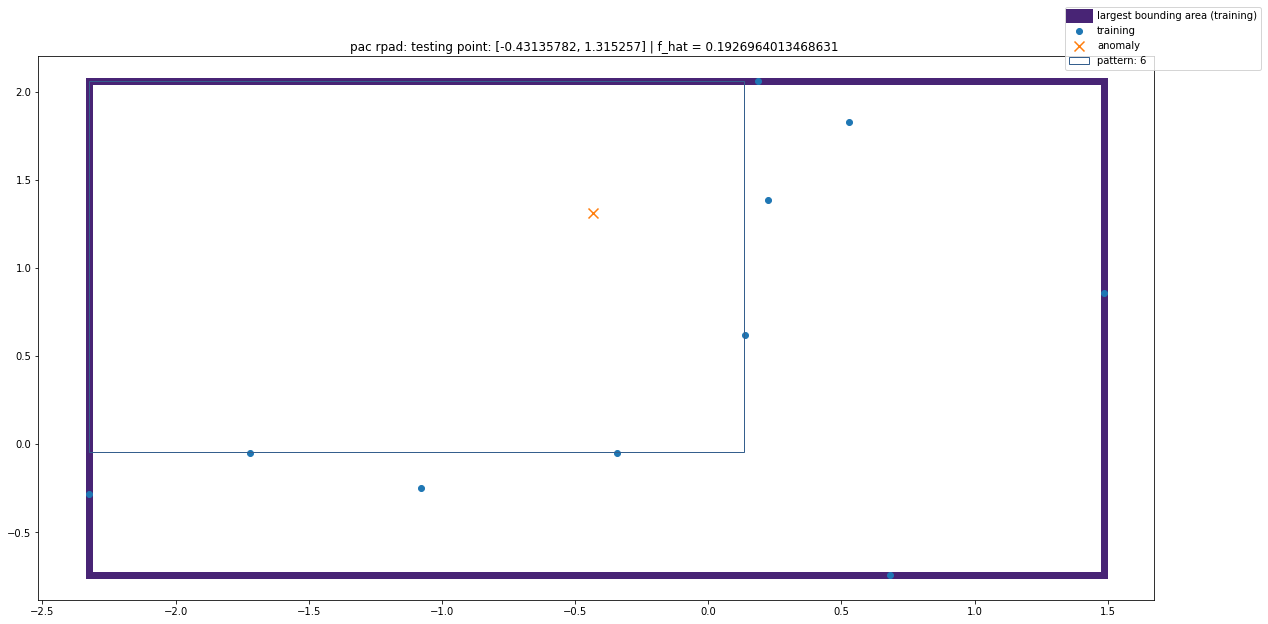

pattern:  [[-2.32450216  0.1355407 ]
 [-0.04661175  2.06290861]]


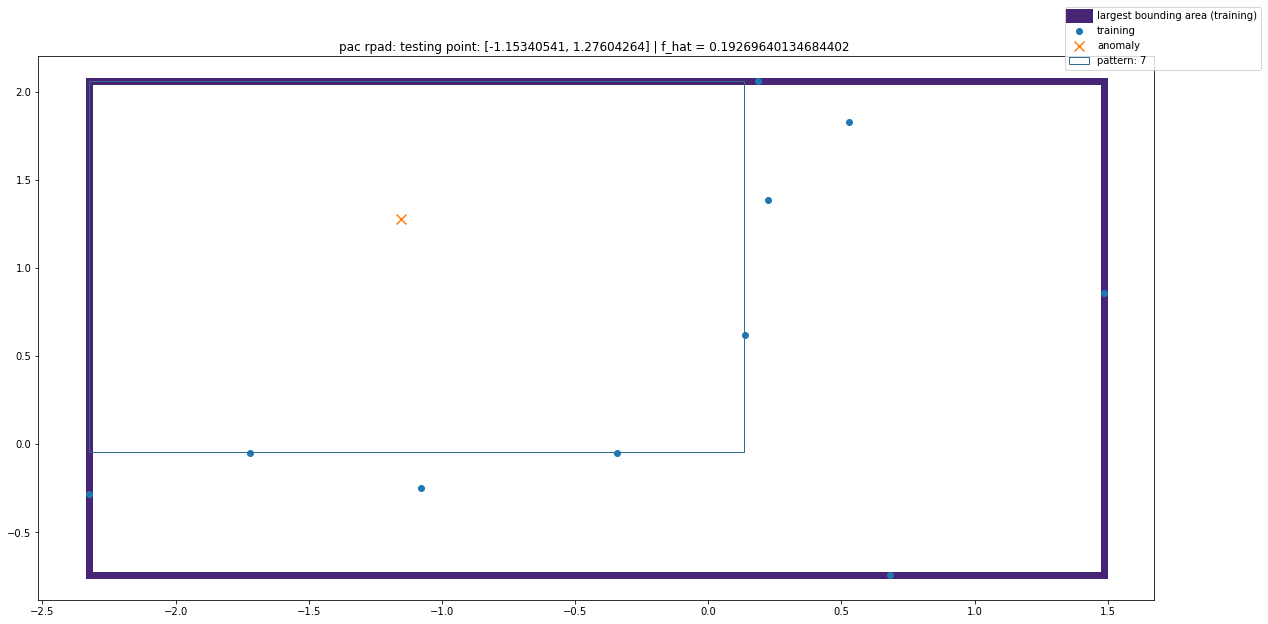

pattern:  [[ 0.68251459  1.4840008 ]
 [-2.32450213  2.06290861]]


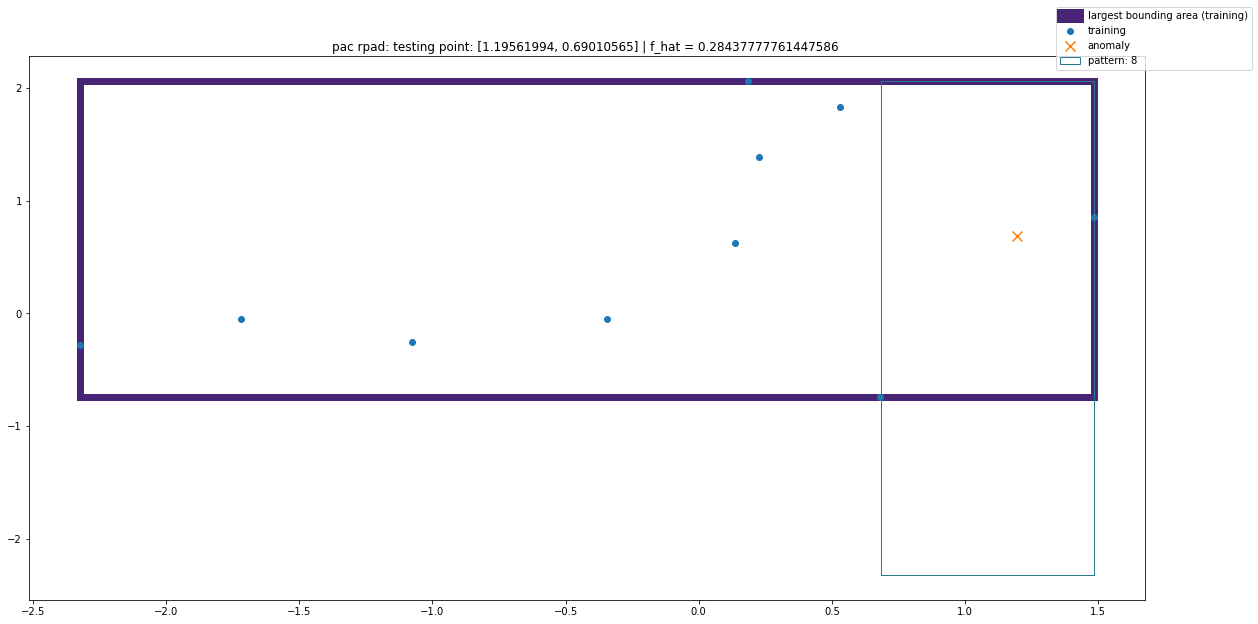

pattern:  None


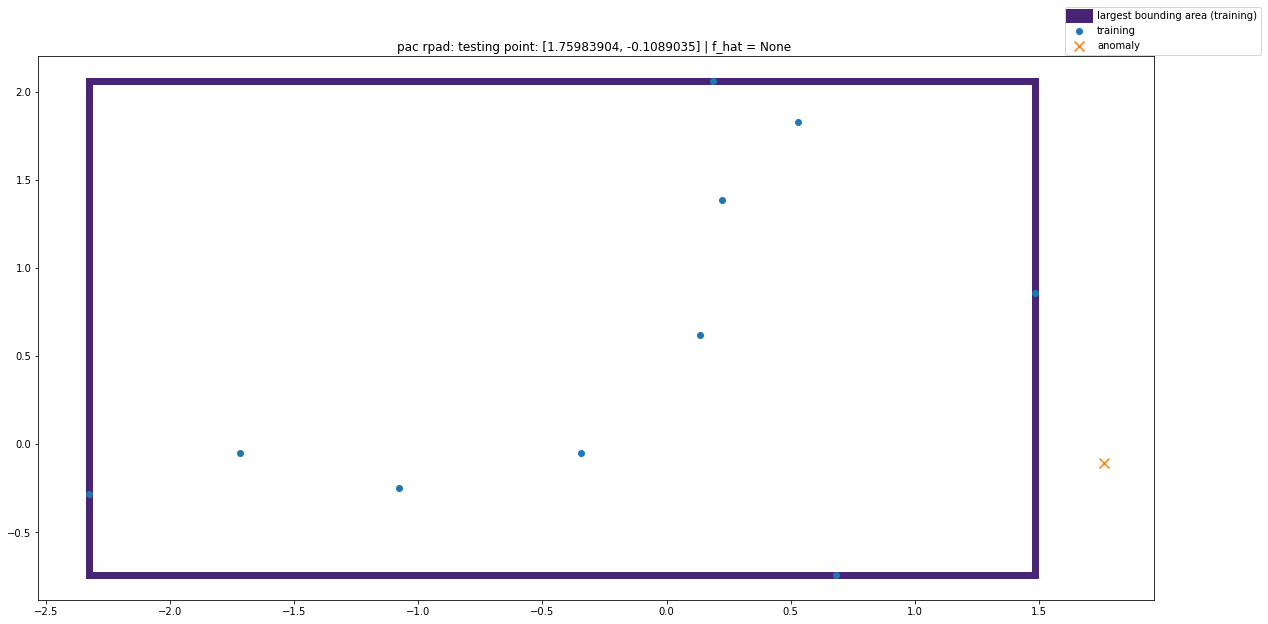

pattern:  [[-2.32350212  0.68051456]
 [-2.32450214 -0.25261948]]


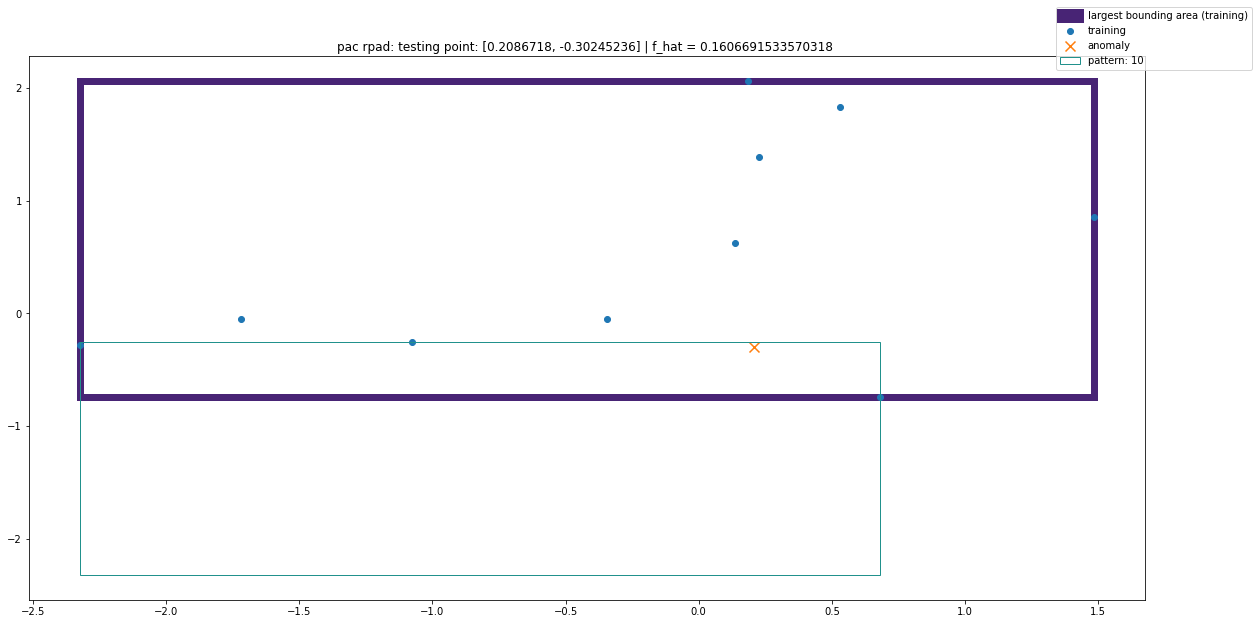

pattern:  None


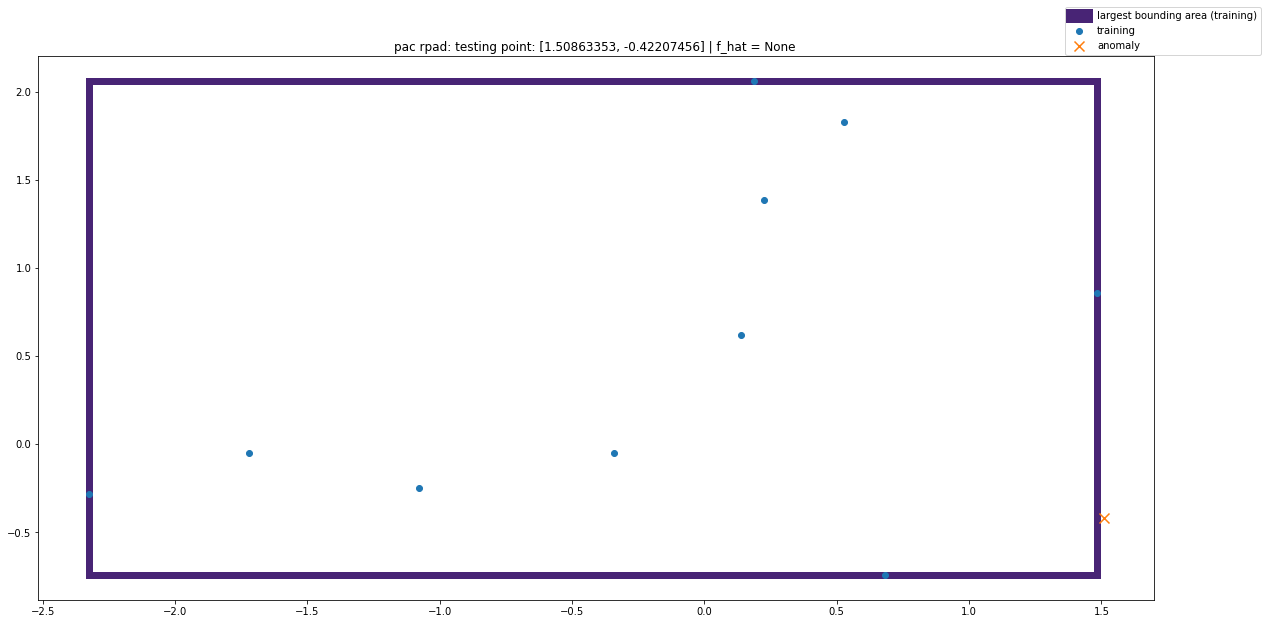

pattern:  [[-2.32450216  0.1355407 ]
 [-0.04661175  2.06290861]]


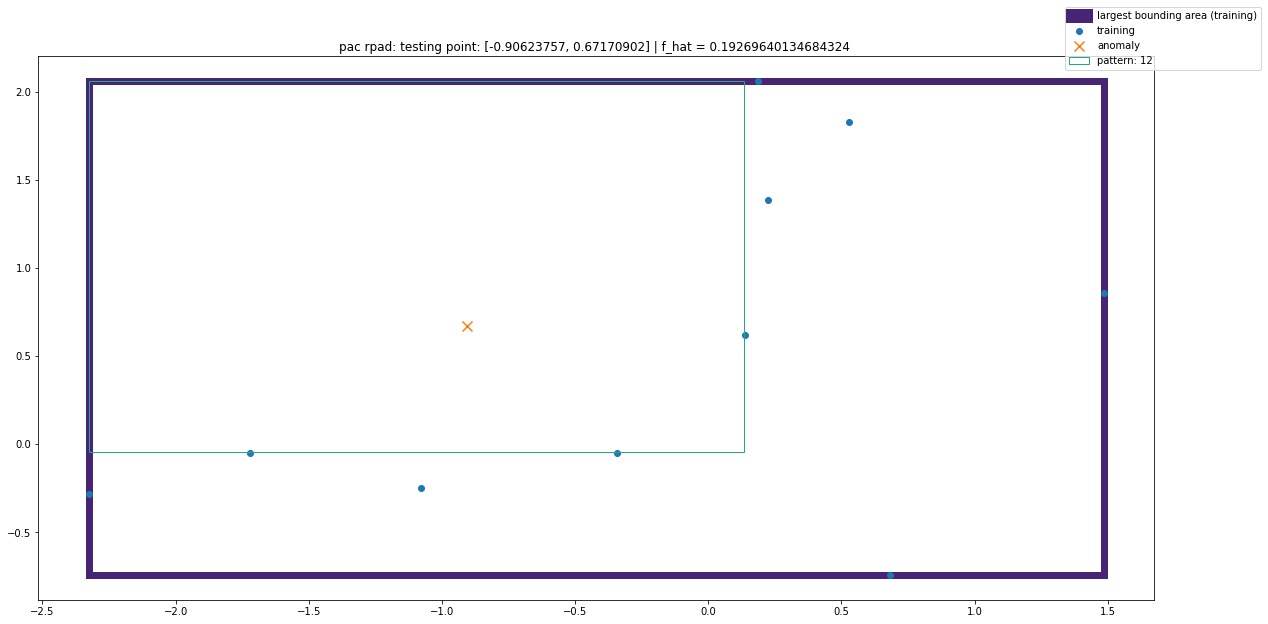

pattern:  [[-2.32350212  0.68051456]
 [-2.32450214 -0.25261948]]


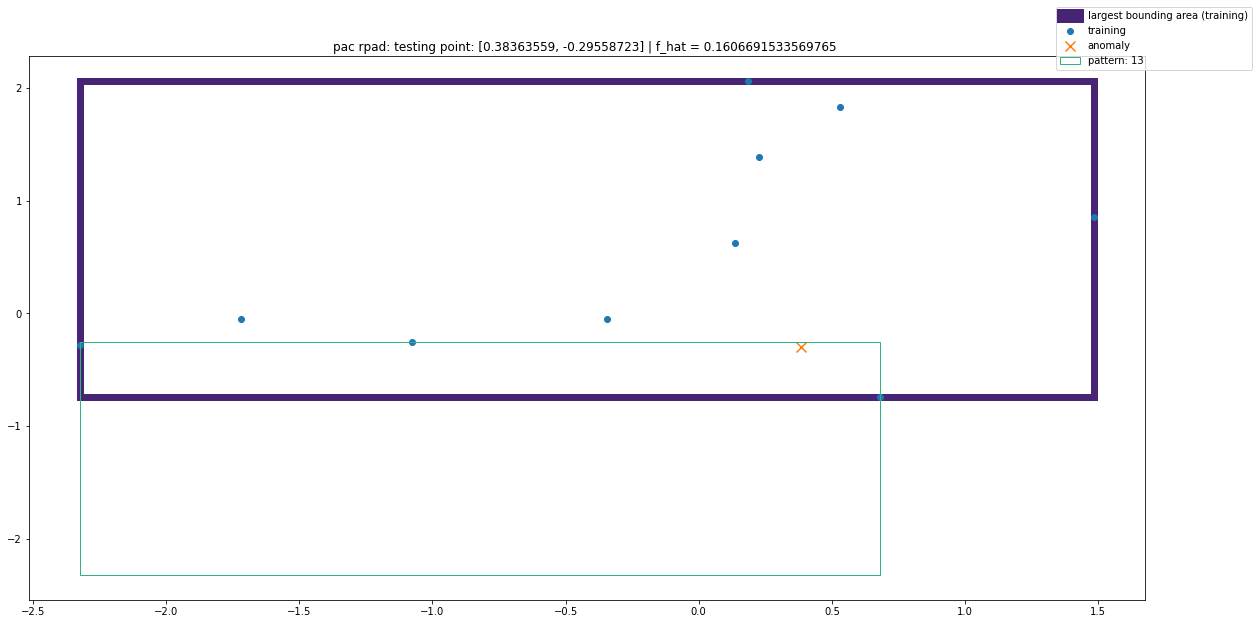

pattern:  None


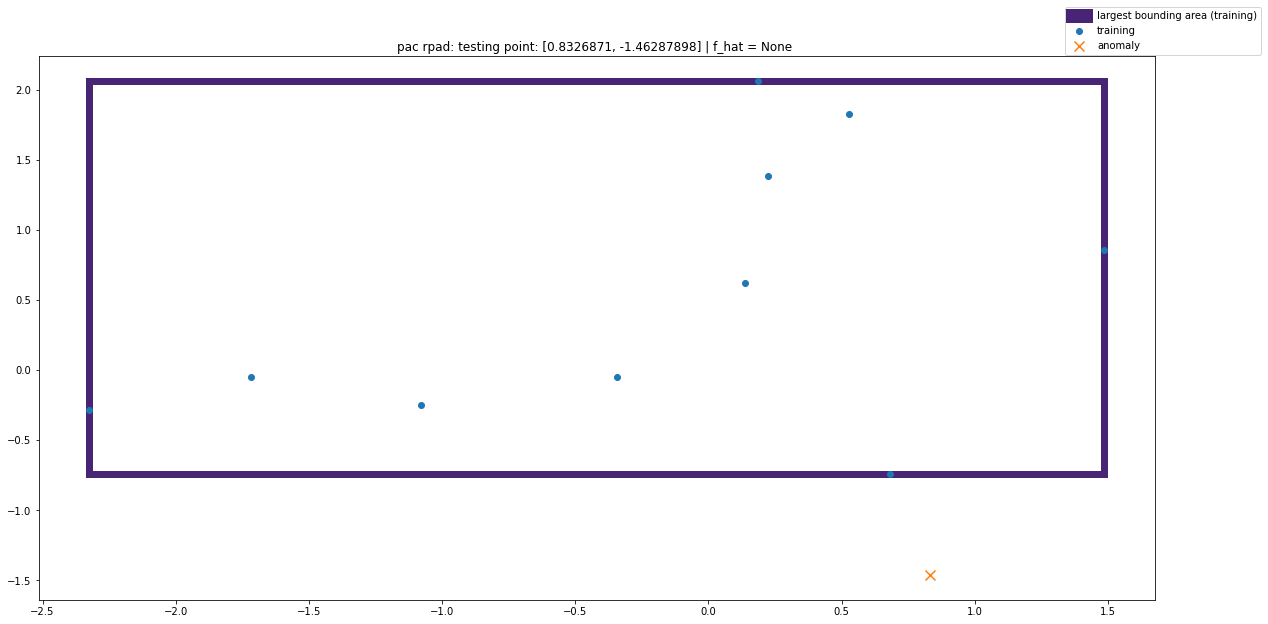

pattern:  [[ 0.68251459  1.4840008 ]
 [-2.32450213  2.06290861]]


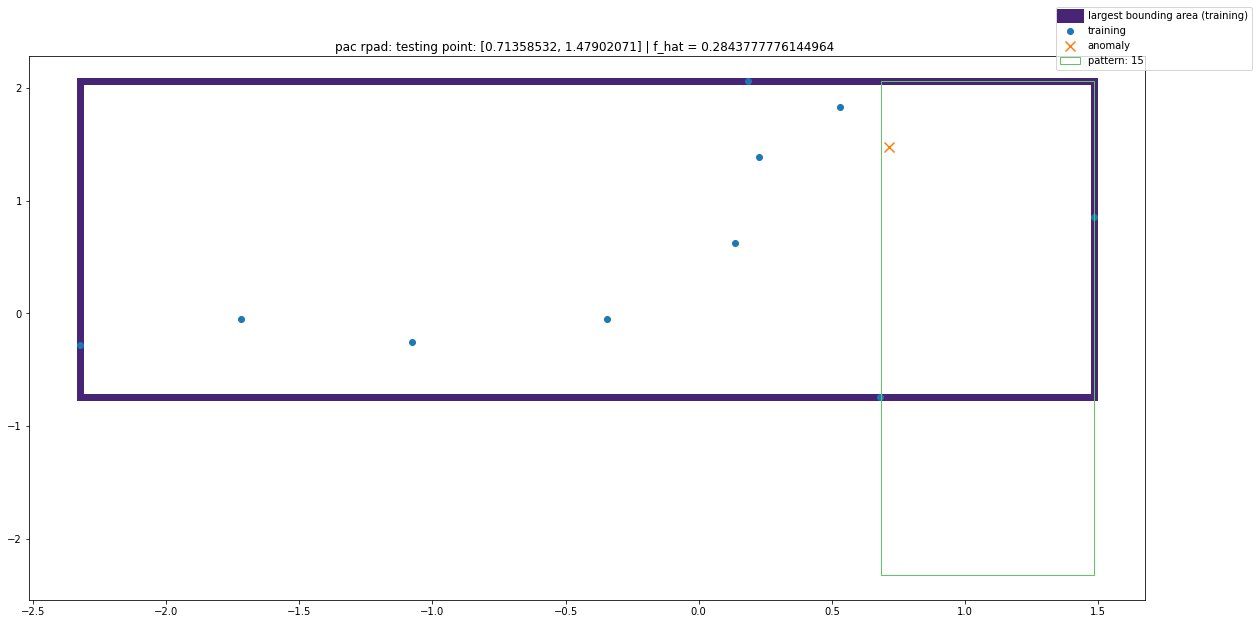

pattern:  [[-2.32450216  0.1355407 ]
 [-0.04661175  2.06290861]]


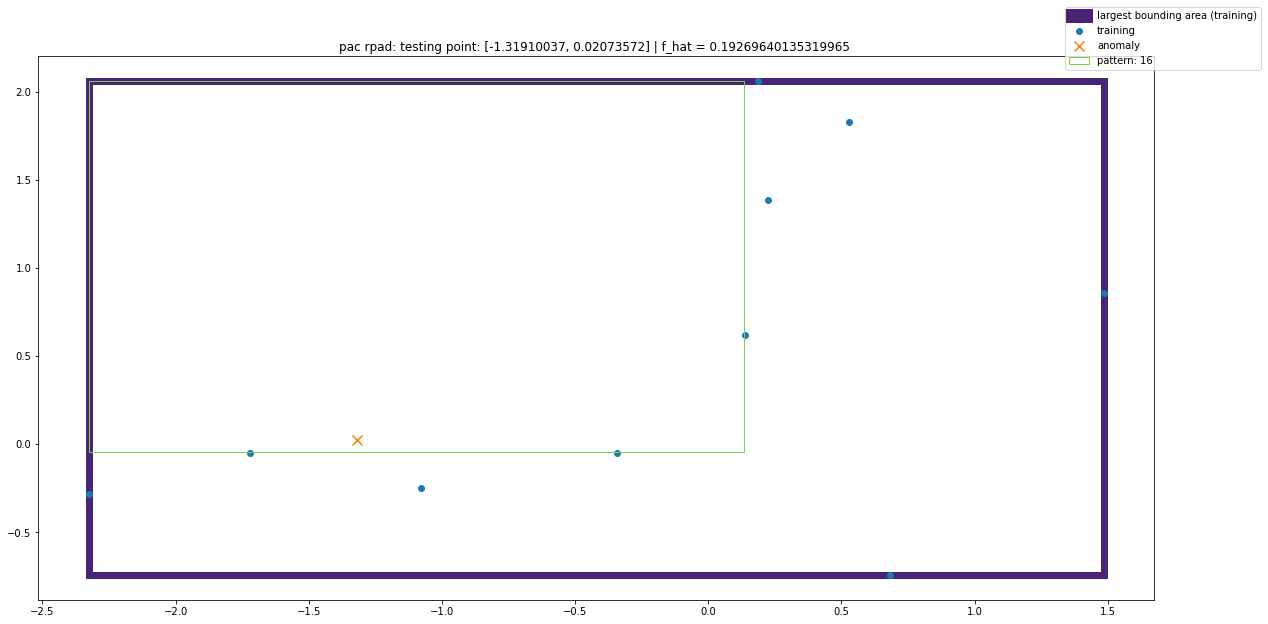

pattern:  None


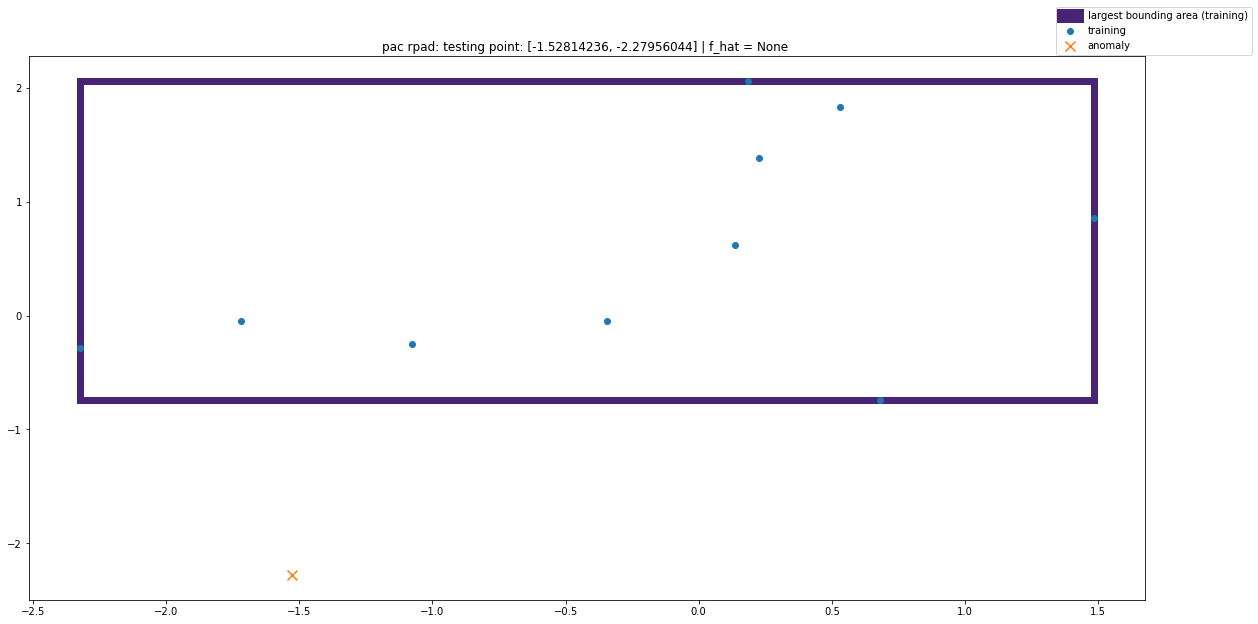

pattern:  [[-2.32350213  1.48500079]
 [-2.32450215 -0.25261947]]


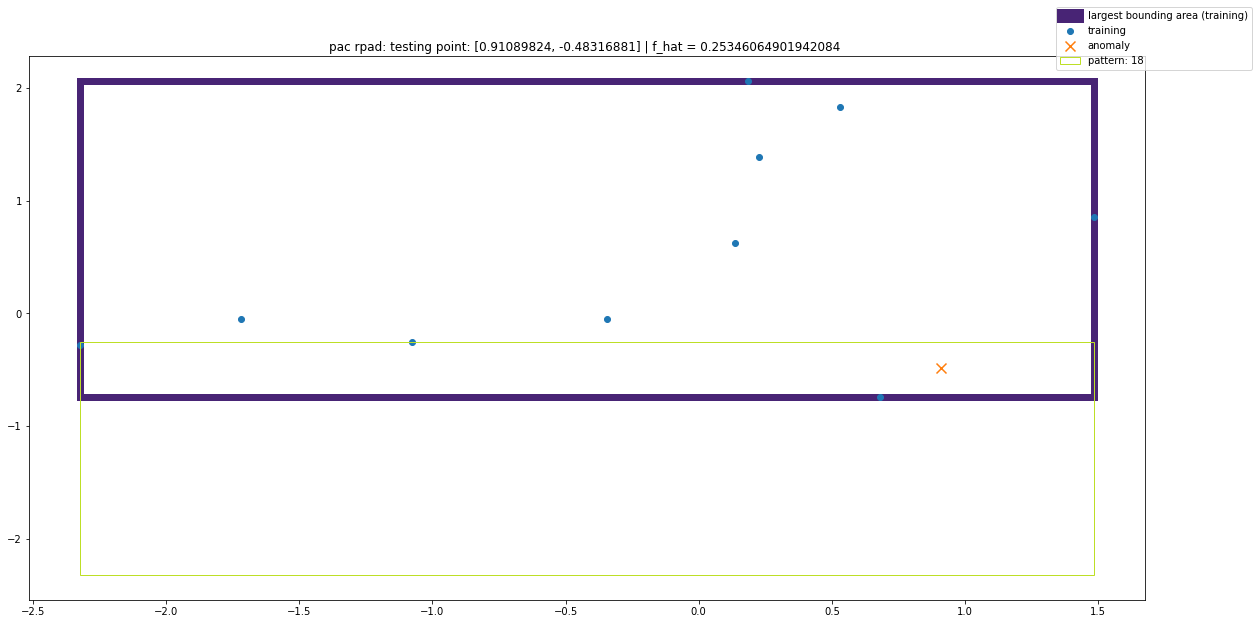

pattern:  [[-2.32350212  0.68051456]
 [-2.32450214 -0.25261948]]


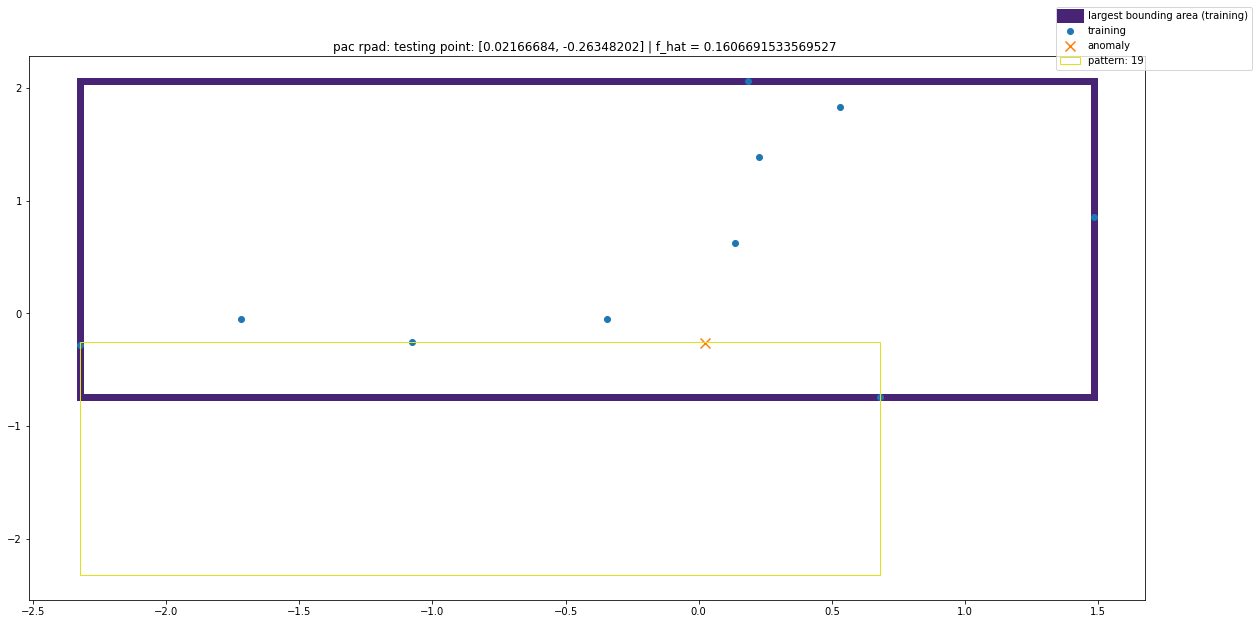

In [53]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)
cmap = plt.get_cmap('viridis')


def draw_largest_bounding_area(interval, ax):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(0.1),
        label= "largest bounding area (training)",
        linewidth=7.0
        )
    )


total = len(testing_points)
for i, (k,v) in enumerate(exact.find_min_f_hat.items()):
    ax = plt.gca()
    k = [float(x) for x in k[1:-1].split(" ") if x]
    point = k # exact.testing_points[i]
    draw_largest_bounding_area(exact.solver.largest_bounding_area.T, ax)
    ax.scatter(x=exact.training_points[:,0], y=exact.training_points[:,1], marker="o", label="training")
    pattern = np.array(v['pattern'])
    anomaly = v['anomaly']
    f_hat = v['objective']
    if anomaly:
        plt.scatter(x=k[0], y=k[1], marker="x", s=100, label="anomaly")
        print("pattern: ", pattern)
        if pattern.all() != None:
            draw2dpattern(pattern, ax, i, total)
    else:
        draw2dpattern(pattern, ax, i, total)
        ax.scatter(x=point[0], y=point[1], marker="x", s=150, label=f"testing point: {k}: normal")
    ax.legend(bbox_to_anchor=(1.1, 1.1))
    plt.title(f"pac rpad: testing point: {k} | f_hat = {f_hat} ")
    plt.show()


In [54]:
# TODO: TEST !!!
    # - implemenent simple test (4 points where the correct answer is already known)
    #   - find the correct pattern, respect the boundaries in each of the dim, use simplest training set and simplest test point 
    #   - training set: (0.0,0.0) (2.0,0.0) (0.0,2.0) (2.0,2.0)
    #   - testing point: (1.0,1.0) 
    #   - unit test to test the functionnalities of the functions 
        # run solver and compare with the expected result 
            # - for the pattern intervals 
            # - for the min area 
            # - for the largest_bounding_area
    
# - one important thing is to think about how to configure the min_area value depending on the dataset.
    # min area: fraction of the bounding area, makes it dependent on the number of training points!  

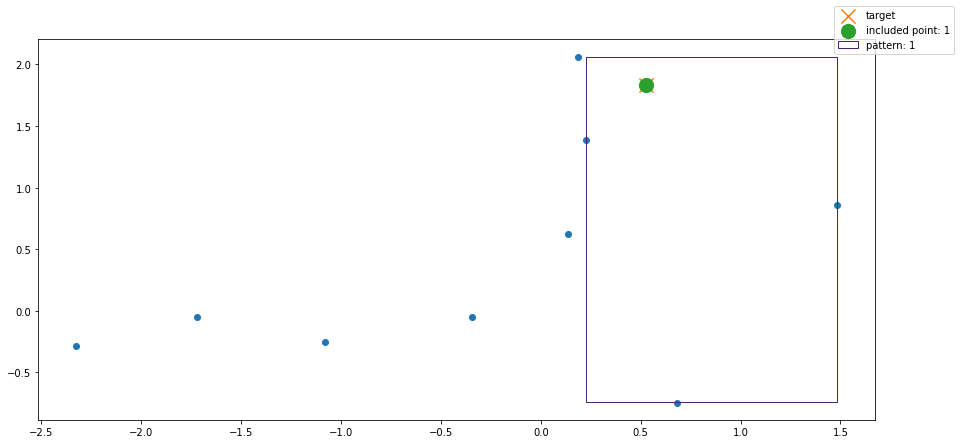

In [55]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

cmap = plt.get_cmap('viridis')

def draw2dpattern(interval, ax, index, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(index/total),
        label=f"pattern: {index}"
        )
    )


plt.scatter(x=training_points[:,0], y=training_points[:,1])
plt.scatter(x=point_to_be_classified[0], y=point_to_be_classified[1], marker="x",  s=200, label="target") 
for i, p in enumerate(included_points):
    plt.scatter(x=p[0], y=p[1], marker="o", s=200, label=f"included point: {np.argwhere(training_points == p)[0,0]}")
ax = plt.gca()
draw2dpattern(intervals, ax, 1, len(training_points))
ax.legend(bbox_to_anchor=(1.1, 1.1))
plt.show()

In [56]:
# min x , min y 
# max x , max y
rare_pattern_detect.largest_bounding_area

array([[-2.32450216, -0.7437402 ],
       [ 1.48500079,  2.06290861]])

In [57]:
from typing import Callable
import numpy as np
import json

class PACRPAD:
    """
    Superclass for all PAC-RPAD implementations
    """
    def __init__(self, tau, epsilon, delta):
        self.tau = tau
        self.epsilon = epsilon
        self.delta = delta
        self.find_min_f_hat = None

    def has_rare_pattern(self, point) -> bool:
        results = self.find_min_f_hat[f"{point}"]
        if results['objective'] != None:
            results['anomaly'] = results['objective'] <= self.tau + self.epsilon / 2
        return results['anomaly']


class AxisAlignedHyperRectanglePACRPAD(PACRPAD):
    def __init__(self, tau, epsilon, delta):
        super().__init__(tau, epsilon, delta)
        self.solver = None 
        self.training_points = None
        self.testing_points = None

    def construct_f_hat_estimator(self, training_points, testing_points, min_area=0.01):
        def _contains(point: np.ndarray, largest_bounding_area) -> bool:
            return all((largest_bounding_area[0,:] <= point.T) & (point.T <= largest_bounding_area[1,:]))

        self.training_points = training_points
        self.testing_points = testing_points
        dict_results = {}

        # Check if testing points lie within the initial pattern bounds
        dummy_solver = RarePatternDetect(self.training_points, min_area=min_area)
        candidates = []
        for idx, test_p in enumerate(self.testing_points):
            # TODO: extract the largest_bounding_area outside of the solver 
            # TODO: extract the functionalities of evaluating to has rare pattern 
            contained = _contains(test_p, dummy_solver.largest_bounding_area)
            if contained:
                # if yes then add testing_points to ensemble of points used to create the pattern space 
                candidates = [train_p for train_p in self.training_points]
                candidates = np.array(candidates)
                candidates = np.append(candidates, [test_p], axis=0)
                self.solver = RarePatternDetect(candidates, min_area=min_area)
                objective = self.solver.classify(test_p)
                intervals = self.solver.extract_pattern()
                included_points = self.solver.extract_points_included_in_pattern()
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : None,
                    'objective' : objective, 
                    'pattern' : intervals.tolist(), 
                    'included points' : included_points.tolist()
                }
            else:
                # else: anomaly = True
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : True,
                    'objective' : None, 
                    'pattern' : None, 
                    'included points' : None
                }

        with open('minlp_results.json', 'w') as fp:
            json.dump(dict_results, fp, indent=4)

        self.find_min_f_hat = dict_results

In [58]:
exact = AxisAlignedHyperRectanglePACRPAD(tau=0.3, epsilon=0.1, delta=0.1)

In [59]:
testing_points = multivariate_normal.rvs(size=(20,2))
testing_points

array([[-0.07326056,  0.10192794],
       [ 0.65419635, -0.30943816],
       [ 0.27704999, -0.1514493 ],
       [-0.71133546, -0.59140119],
       [ 1.06704117, -0.35698109],
       [ 0.10663571, -0.67249216],
       [-0.15986318,  2.0078214 ],
       [ 0.67636671, -0.12535743],
       [ 0.52251944,  1.19615498],
       [ 0.5872502 ,  0.54368713],
       [-0.09754814, -0.79735432],
       [-1.64076346,  1.18369678],
       [-0.81989276,  1.63298867],
       [-1.21329026, -1.05384855],
       [-2.85644177, -0.49488471],
       [-1.43926311, -0.20522096],
       [-0.39314664, -0.53728382],
       [ 0.56548353, -0.87064694],
       [ 0.80698486, -0.64790262],
       [ 0.19388638,  1.22014691]])

In [60]:
exact.construct_f_hat_estimator(training_points, testing_points, min_area=0)
labels_pac_minlp = [exact.has_rare_pattern(x) for x in exact.testing_points]
labels_pac_minlp

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 106 constraints (1 nonlinear) and 0 disjunctions, with 61 variables, of which 55 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



model.interval_lengths:  interval_lengths
model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.17181e-08            inf    1.17181e-08      nan%      0.15
         1              MILP         0.0755546            inf      0.0755546      nan%      0.19
*        1         Fixed NLP          0.284133       0.284133      0.0755546    73.41%      0.30
         2              MILP         0.0755546       0.284133      0.0755546    73.41%      0.34
         2         Fixed NLP          0.477645       0.284133      0.0755546    73.41%      0.43
         3              MILP          0.149308       0.284133       0.149308    47.45%      0.47
*        3         Fixed NLP          0.192696       0.192696       0.149308    22.52%      0.58
         4              MILP          0.192696       0.192696       0.192696     0.00%      0.62
MindtPy exiting on bound convergence. |Primal Bound: 0.19269639385752316 - Dual Bound: 0.192696398320962| <= (absolute tolerance 0.0001)  

 Primal integral          :    0.0390 
 Dual integral            :    0.0562 
 Prima

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       9.44784e-09            inf    9.44784e-09      nan%      0.13
         1              MILP         0.0885969            inf      0.0885969      nan%      0.17
*        1         Fixed NLP          0.162981       0.162981      0.0885969    45.64%      0.29
         2              MILP          0.130554       0.162981       0.130554    19.90%      0.32
         2         Fixed NLP            1.5115       0.162981       0.130554    19.90%      0.41
         3              MILP          0.132774       0.162981       0.132774    18.53%      0.45
         3         Fixed NLP          0.529491       0.162981       0.132774    18.53%      0.53
         4              MILP          0.160635       0.162981       0.160635     1.44%      0.57
*        4         Fixed NLP          0.160669       0.160669       0.160635     0.02%      0.67
MindtPy exiting on bound convergence. |Primal Bound: 0.16066914586280936 - Dual Bound: 0.160635086156638| <= (absolute toleranc

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.14259e-08            inf    1.14259e-08      nan%      0.14
         1              MILP         0.0779301            inf      0.0779301      nan%      0.18
*        1         Fixed NLP           1.43147        1.43147      0.0779301    94.56%      0.30
         2              MILP         0.0779301        1.43147      0.0779301    94.56%      0.33
*        2         Fixed NLP           1.31478        1.31478      0.0779301    94.07%      0.43
         3              MILP         0.0779301        1.31478      0.0779301    94.07%      0.46
*        3         Fixed NLP          0.564252       0.564252      0.0779301    86.19%      0.57
         4              MILP         0.0779301       0.564252      0.0779301    86.19%      0.60
*        4         Fixed NLP           0.25018        0.25018      0.0779301    68.85%      0.70
         5              MILP          0.224801        0.25018       0.224801    10.14%      0.74
         5         Fixed NLP  

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.18477e-08            inf    1.18477e-08      nan%      0.15
         1              MILP         0.0755213            inf      0.0755213      nan%      0.19
*        1         Fixed NLP          0.247246       0.247246      0.0755213    69.46%      0.30
         2              MILP          0.115897       0.247246       0.115897    53.12%      0.34
*        2         Fixed NLP          0.160669       0.160669       0.115897    27.87%      0.43
         3              MILP          0.118862       0.160669       0.118862    26.02%      0.47
         3         Fixed NLP           0.31058       0.160669       0.118862    26.02%      0.56
         4              MILP          0.160669       0.160669       0.160669     0.00%      0.60
MindtPy exiting on bound convergence. |Primal Bound: 0.16066914586289596 - Dual Bound: 0.160669145953781| <= (absolute tolerance 0.0001)  

 Primal integral          :    0.0239 
 Dual integral            :    0.0395 
 Prima

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.19885e-08            inf    1.19885e-08      nan%      0.17
         1              MILP         0.0742063            inf      0.0742063      nan%      0.20
*        1         Fixed NLP           2.13807        2.13807      0.0742063    96.53%      0.30
         2              MILP         0.0742063        2.13807      0.0742063    96.53%      0.34
*        2         Fixed NLP          0.570739       0.570739      0.0742063    87.00%      0.45
         3              MILP         0.0742063       0.570739      0.0742063    87.00%      0.49
         3         Fixed NLP          0.611065       0.570739      0.0742063    87.00%      0.57
         4              MILP         0.0742063       0.570739      0.0742063    87.00%      0.60
*        4         Fixed NLP          0.284378       0.284378      0.0742063    73.91%      0.71
         5              MILP          0.116609       0.284378       0.116609    58.99%      0.75
         5         Fixed NLP  

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.17196e-08            inf    1.17196e-08      nan%      0.13
         1              MILP         0.0754479            inf      0.0754479      nan%      0.17
*        1         Fixed NLP          0.477754       0.477754      0.0754479    84.21%      0.27
         2              MILP         0.0754479       0.477754      0.0754479    84.21%      0.30
*        2         Fixed NLP          0.171712       0.171712      0.0754479    56.06%      0.42
         3              MILP          0.160045       0.171712       0.160045     6.79%      0.45
*        3         Fixed NLP          0.160669       0.160669       0.160045     0.39%      0.55
         4              MILP          0.160669       0.160669       0.160669     0.00%      0.59
MindtPy exiting on bound convergence. |Primal Bound: 0.16066914586289588 - Dual Bound: 0.160669145953781| <= (absolute tolerance 0.0001)  

 Primal integral          :    0.0796 
 Dual integral            :    0.0354 
 Prima

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.22998e-08            inf    1.22998e-08      nan%      0.18
         1              MILP         0.0701473            inf      0.0701473      nan%      0.22
*        1         Fixed NLP          0.477754       0.477754      0.0701473    85.32%      0.32
         2              MILP         0.0701473       0.477754      0.0701473    85.32%      0.36
         2         Fixed NLP          0.589743       0.477754      0.0701473    85.32%      0.44
         3              MILP         0.0701473       0.477754      0.0701473    85.32%      0.47
*        3         Fixed NLP          0.357952       0.357952      0.0701473    80.40%      0.57
         4              MILP          0.095518       0.357952       0.095518    73.32%      0.61
*        4         Fixed NLP          0.192696       0.192696       0.095518    50.43%      0.72
         5              MILP          0.192696       0.192696       0.192696     0.00%      0.76
MindtPy exiting on bound conve

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.17689e-08            inf    1.17689e-08      nan%      0.16
         1              MILP         0.0750262            inf      0.0750262      nan%      0.19
*        1         Fixed NLP          0.810026       0.810026      0.0750262    90.74%      0.29
         2              MILP         0.0750262       0.810026      0.0750262    90.74%      0.33
*        2         Fixed NLP          0.349207       0.349207      0.0750262    78.52%      0.43
         3              MILP         0.0750262       0.349207      0.0750262    78.52%      0.46
         3         Fixed NLP           1.31478       0.349207      0.0750262    78.52%      0.54
         4              MILP          0.218354       0.349207       0.218354    37.47%      0.58
*        4         Fixed NLP           0.25018        0.25018       0.218354    12.72%      0.69
         5              MILP           0.25018        0.25018        0.25018     0.00%      0.73
MindtPy exiting on bound conve

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.12851e-08            inf    1.12851e-08      nan%      0.17
         1              MILP         0.0805109            inf      0.0805109      nan%      0.20
*        1         Fixed NLP          0.373693       0.373693      0.0805109    78.46%      0.31
         2              MILP         0.0805109       0.373693      0.0805109    78.46%      0.34
         2         Fixed NLP          0.500582       0.373693      0.0805109    78.46%      0.43
         3              MILP          0.161022       0.373693       0.161022    56.91%      0.47
*        3         Fixed NLP          0.367063       0.367063       0.161022    56.13%      0.58
         4              MILP          0.256291       0.367063       0.256291    30.18%      0.62
         4         Fixed NLP          0.529491       0.367063       0.256291    30.18%      0.69
         5              MILP          0.295585       0.367063       0.295585    19.47%      0.73
*        5         Fixed NLP  

model.interval_lengths:  interval_lengths


         -       Relaxed NLP        1.1885e-08            inf     1.1885e-08      nan%      0.15
         1              MILP         0.0750853            inf      0.0750853      nan%      0.18
*        1         Fixed NLP           3.14364        3.14364      0.0750853    97.61%      0.30
         2              MILP         0.0750853        3.14364      0.0750853    97.61%      0.33
*        2         Fixed NLP          0.393278       0.393278      0.0750853    80.91%      0.43
         3              MILP         0.0750853       0.393278      0.0750853    80.91%      0.47
         3         Fixed NLP            1.5115       0.393278      0.0750853    80.91%      0.56
         4              MILP         0.0750853       0.393278      0.0750853    80.91%      0.60
         4         Fixed NLP          0.496224       0.393278      0.0750853    80.91%      0.69
         5              MILP          0.218319       0.393278       0.218319    44.49%      0.73
         5         Fixed NLP  

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.19777e-08            inf    1.19777e-08      nan%      0.17
         1              MILP         0.0743522            inf      0.0743522      nan%      0.20
*        1         Fixed NLP          0.345199       0.345199      0.0743522    78.46%      0.30
         2              MILP         0.0743522       0.345199      0.0743522    78.46%      0.33
         2         Fixed NLP          0.377095       0.345199      0.0743522    78.46%      0.42
         3              MILP         0.0743522       0.345199      0.0743522    78.46%      0.45
*        3         Fixed NLP          0.255744       0.255744      0.0743522    70.93%      0.57
         4              MILP          0.172068       0.255744       0.172068    32.72%      0.60
*        4         Fixed NLP          0.192696       0.192696       0.172068    10.71%      0.71
         5              MILP          0.192696       0.192696       0.192696     0.00%      0.75
MindtPy exiting on bound conve

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       9.30349e-09            inf    9.30349e-09      nan%      0.13
         1              MILP         0.0741094            inf      0.0741094      nan%      0.17
*        1         Fixed NLP           0.41882        0.41882      0.0741094    82.31%      0.28
         2              MILP         0.0741094        0.41882      0.0741094    82.31%      0.31
*        2         Fixed NLP          0.192866       0.192866      0.0741094    61.57%      0.41
         3              MILP          0.119724       0.192866       0.119724    37.92%      0.45
         3         Fixed NLP           0.31058       0.192866       0.119724    37.92%      0.54
         4              MILP          0.192696       0.192866       0.192696     0.09%      0.58
MindtPy exiting on bound convergence. |Primal Bound: 0.1928661863664349 - Dual Bound: 0.192696285904666| / (1e-10 + |Primal Bound|:0.1928661863664349) <= relative tolerance: 0.001
 Primal integral          :    0.0578 
 Dual

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.16072e-08            inf    1.16072e-08      nan%      0.12
         1              MILP         0.0768444            inf      0.0768444      nan%      0.16
*        1         Fixed NLP          0.356954       0.356954      0.0768444    78.47%      0.27
         2              MILP         0.0768444       0.356954      0.0768444    78.47%      0.31
         2         Fixed NLP           1.31409       0.356954      0.0768444    78.47%      0.41
         3              MILP          0.114312       0.356954       0.114312    67.98%      0.45
*        3         Fixed NLP          0.314495       0.314495       0.114312    63.65%      0.56
         4              MILP          0.261515       0.314495       0.261515    16.85%      0.60
*        4         Fixed NLP          0.292823       0.292823       0.261515    10.69%      0.70
         5              MILP          0.292823       0.292823       0.292823     0.00%      0.74
MindtPy exiting on bound conve

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.20437e-08            inf    1.20437e-08      nan%      0.15
         1              MILP         0.0724499            inf      0.0724499      nan%      0.19
*        1         Fixed NLP           1.09733        1.09733      0.0724499    93.40%      0.30
         2              MILP         0.0724499        1.09733      0.0724499    93.40%      0.33
*        2         Fixed NLP          0.535726       0.535726      0.0724499    86.48%      0.45
         3              MILP         0.0724499       0.535726      0.0724499    86.48%      0.48
*        3         Fixed NLP          0.162981       0.162981      0.0724499    55.55%      0.60
         4              MILP         0.0989305       0.162981      0.0989305    39.30%      0.64
         4         Fixed NLP           0.31058       0.162981      0.0989305    39.30%      0.73
         5              MILP          0.160635       0.162981       0.160635     1.44%      0.77
*        5         Fixed NLP  

model.interval_lengths:  interval_lengths


         -       Relaxed NLP       1.13843e-08            inf    1.13843e-08      nan%      0.15
         1              MILP         0.0789685            inf      0.0789685      nan%      0.18
*        1         Fixed NLP          0.796527       0.796527      0.0789685    90.09%      0.28
         2              MILP         0.0789685       0.796527      0.0789685    90.09%      0.32
*        2         Fixed NLP          0.611065       0.611065      0.0789685    87.08%      0.42
         3              MILP         0.0789685       0.611065      0.0789685    87.08%      0.45
*        3         Fixed NLP          0.284378       0.284378      0.0789685    72.23%      0.56
         4              MILP          0.116609       0.284378       0.116609    58.99%      0.60
         4         Fixed NLP          0.401373       0.284378       0.116609    58.99%      0.69
         5              MILP          0.158942       0.284378       0.158942    44.11%      0.73
*        5         Fixed NLP  

model.interval_lengths:  interval_lengths


         -       Relaxed NLP        1.1539e-08            inf     1.1539e-08      nan%      0.17
         1              MILP         0.0771724            inf      0.0771724      nan%      0.21
*        1         Fixed NLP          0.719935       0.719935      0.0771724    89.28%      0.31
         2              MILP         0.0771724       0.719935      0.0771724    89.28%      0.35
*        2         Fixed NLP          0.446131       0.446131      0.0771724    82.70%      0.44
         3              MILP         0.0771724       0.446131      0.0771724    82.70%      0.48
*        3         Fixed NLP          0.345108       0.345108      0.0771724    77.64%      0.59
         4              MILP           0.13431       0.345108        0.13431    61.08%      0.63
         4         Fixed NLP           2.64396       0.345108        0.13431    61.08%      0.71
         5              MILP          0.151831       0.345108       0.151831    56.00%      0.75
*        5         Fixed NLP  

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

pattern:  [[-2.32450216  0.1355407 ]
 [-0.04661175  2.06290861]]


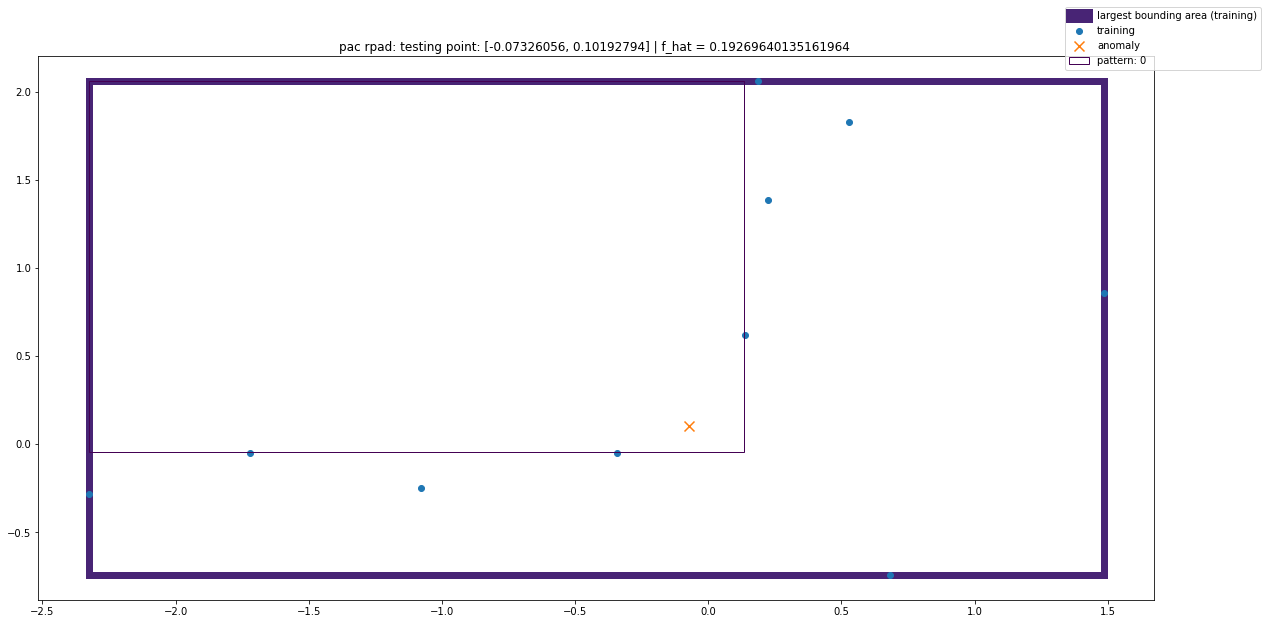

pattern:  [[-2.32350212  0.68051456]
 [-2.32450214 -0.25261948]]


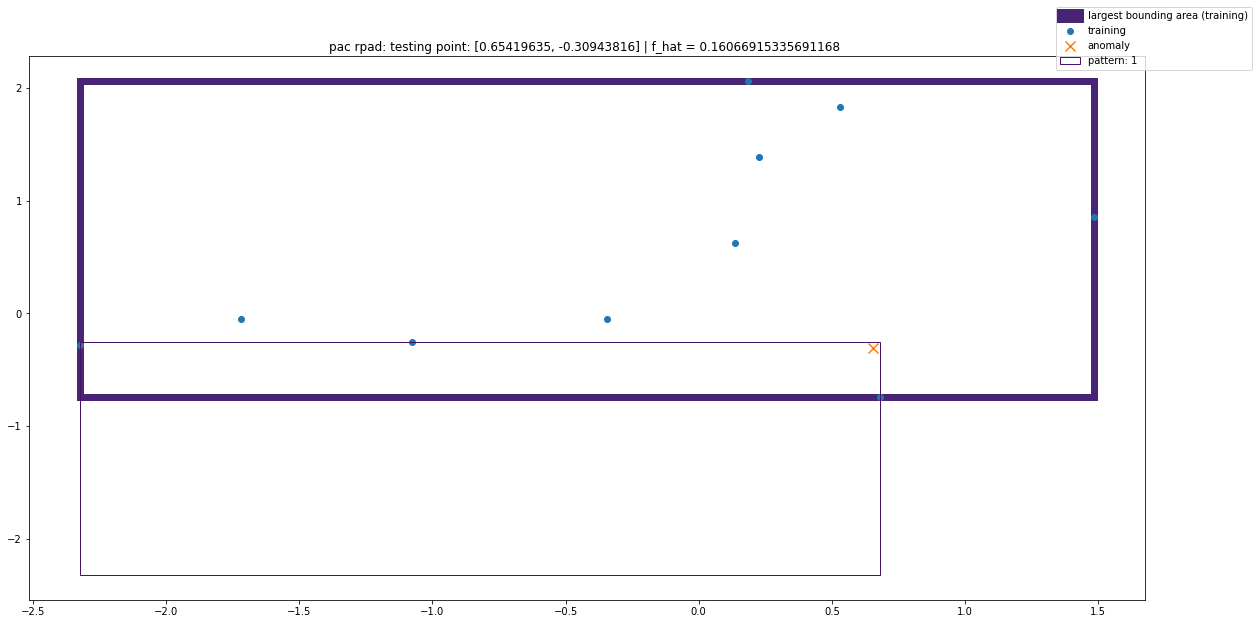

pattern:  [[-1.07751103  0.68051459]
 [-2.32450215 -0.05086057]]


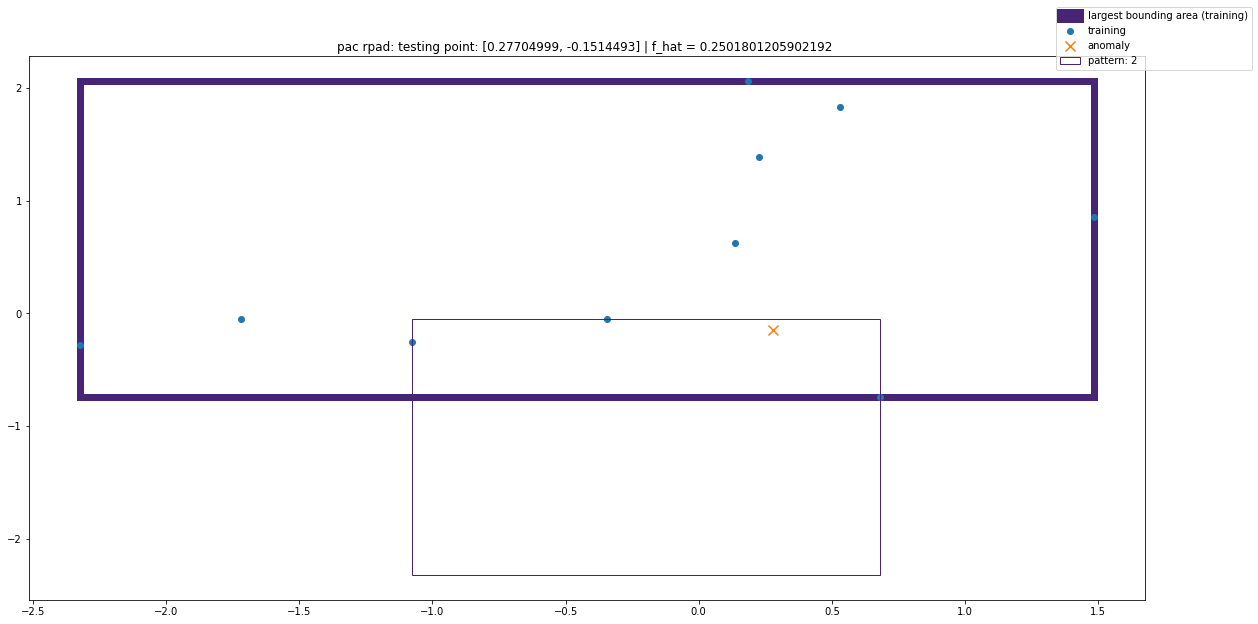

pattern:  [[-2.32350212  0.68051456]
 [-2.32450214 -0.25261948]]


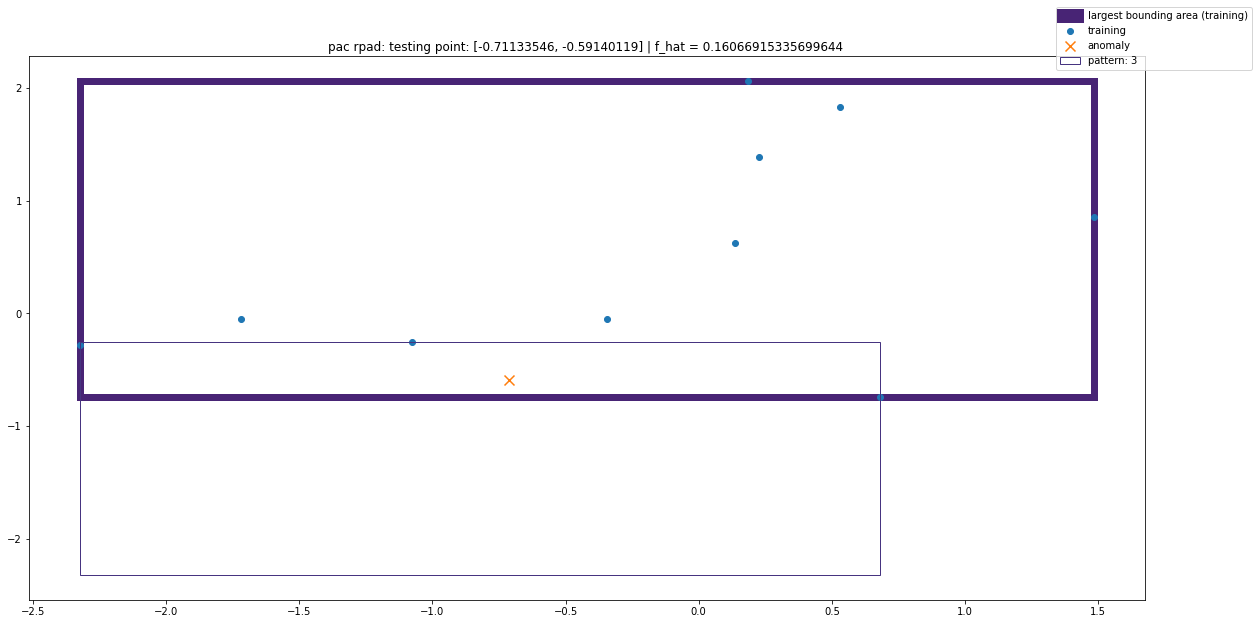

pattern:  [[-2.32350213  1.48500079]
 [-2.32450215 -0.25261947]]


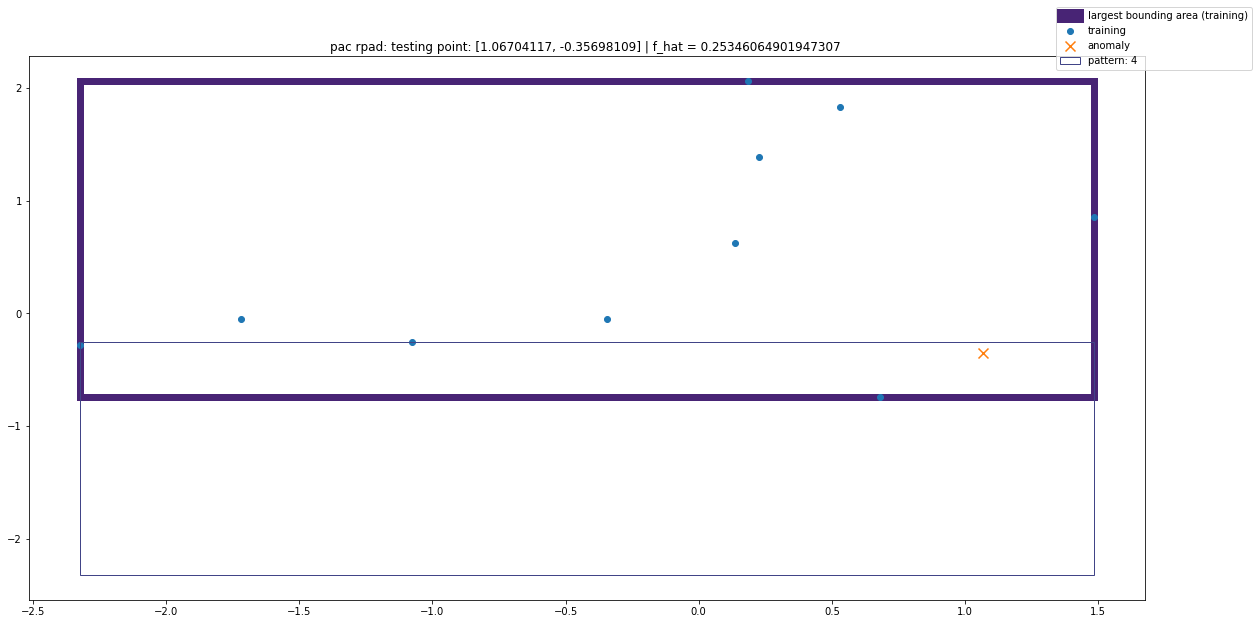

pattern:  [[-2.32350212  0.68051456]
 [-2.32450214 -0.25261948]]


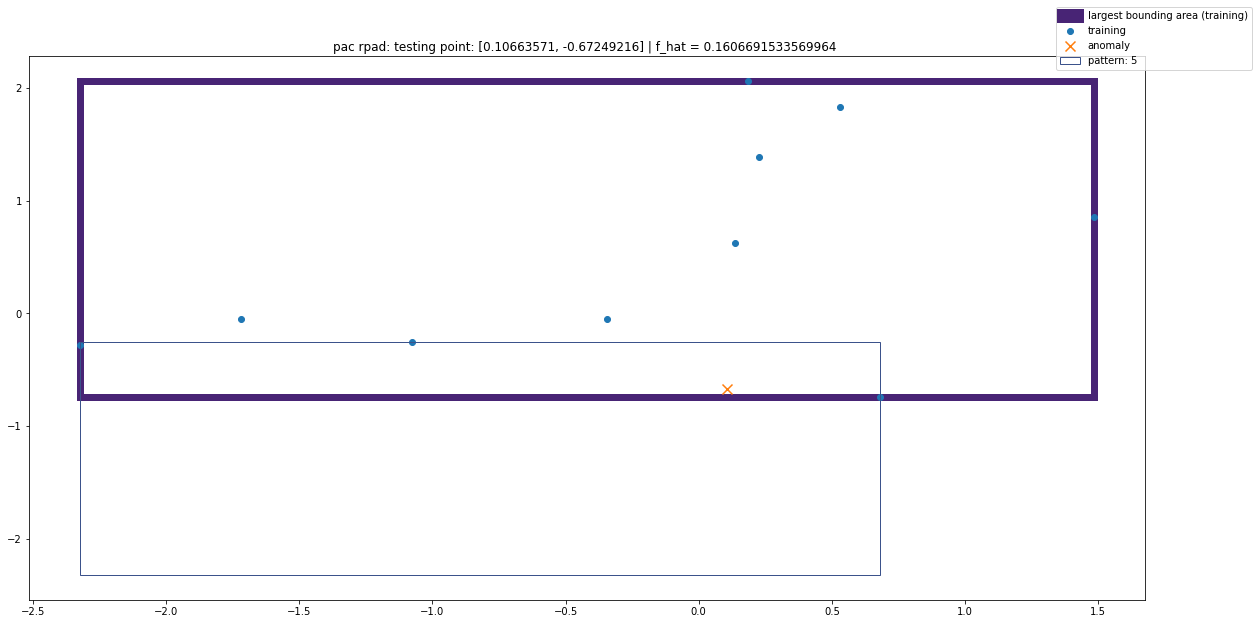

pattern:  [[-2.32450216  0.1355407 ]
 [-0.04661175  2.06290861]]


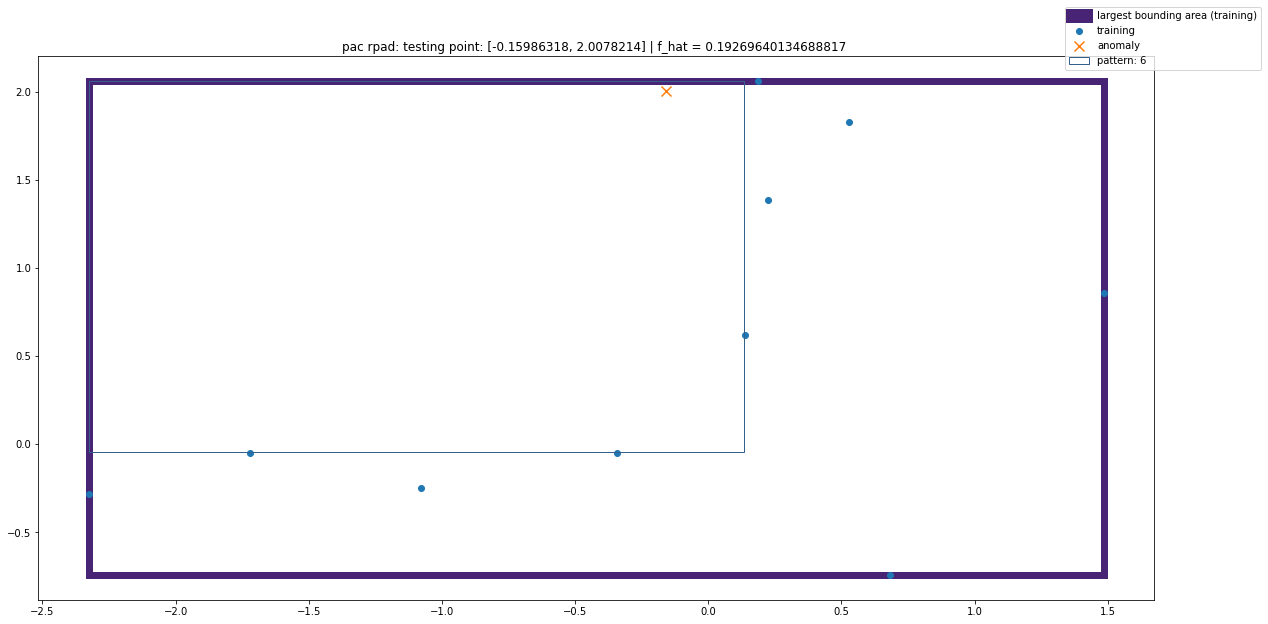

pattern:  [[-1.07751103  0.68051459]
 [-2.32450215 -0.05086057]]


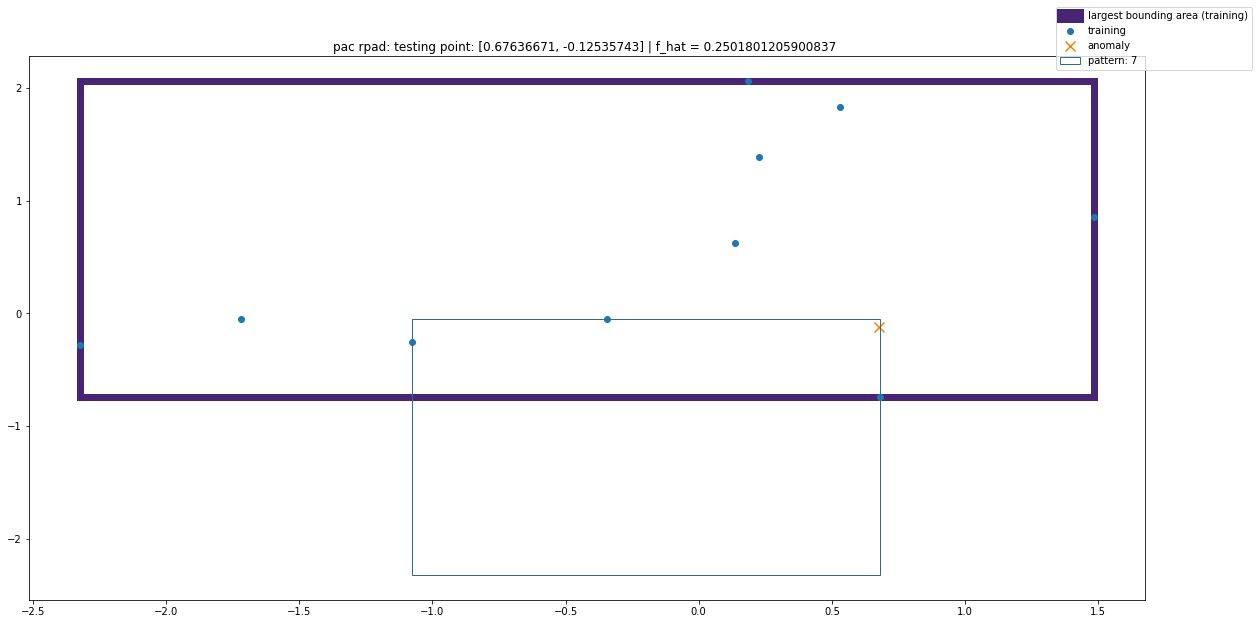

pattern:  [[ 0.2257663   1.48400079]
 [-0.74274019  1.82857495]]


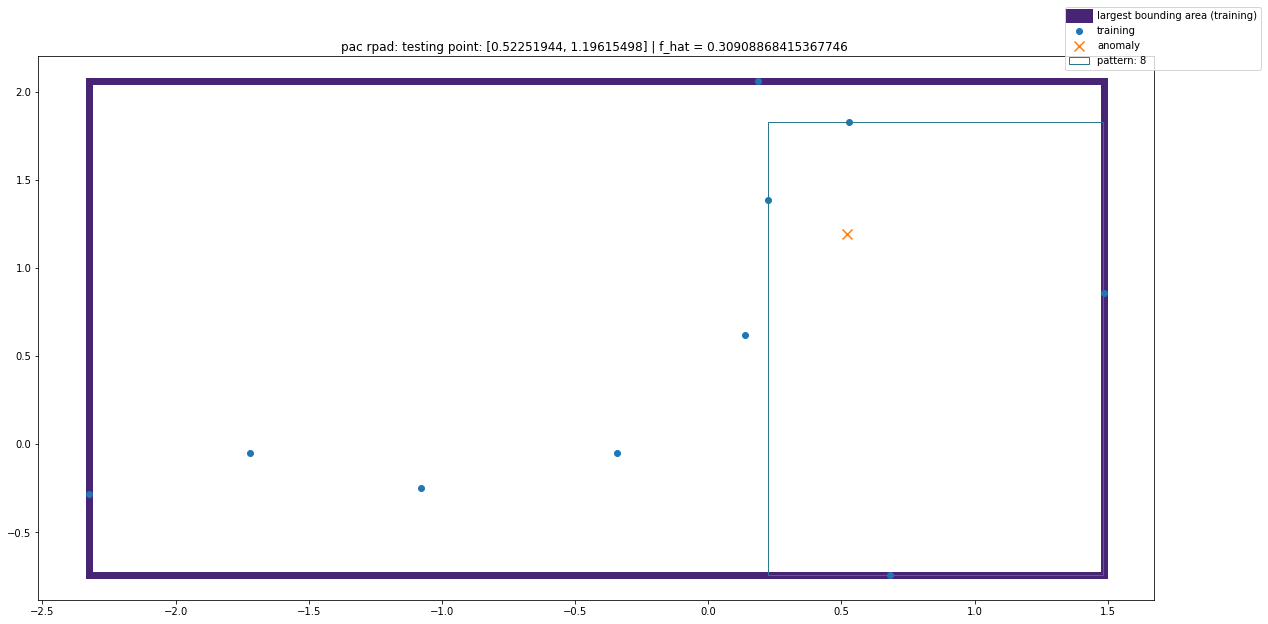

pattern:  [[ 0.2257663   1.48400079]
 [-0.74274019  1.82857495]]


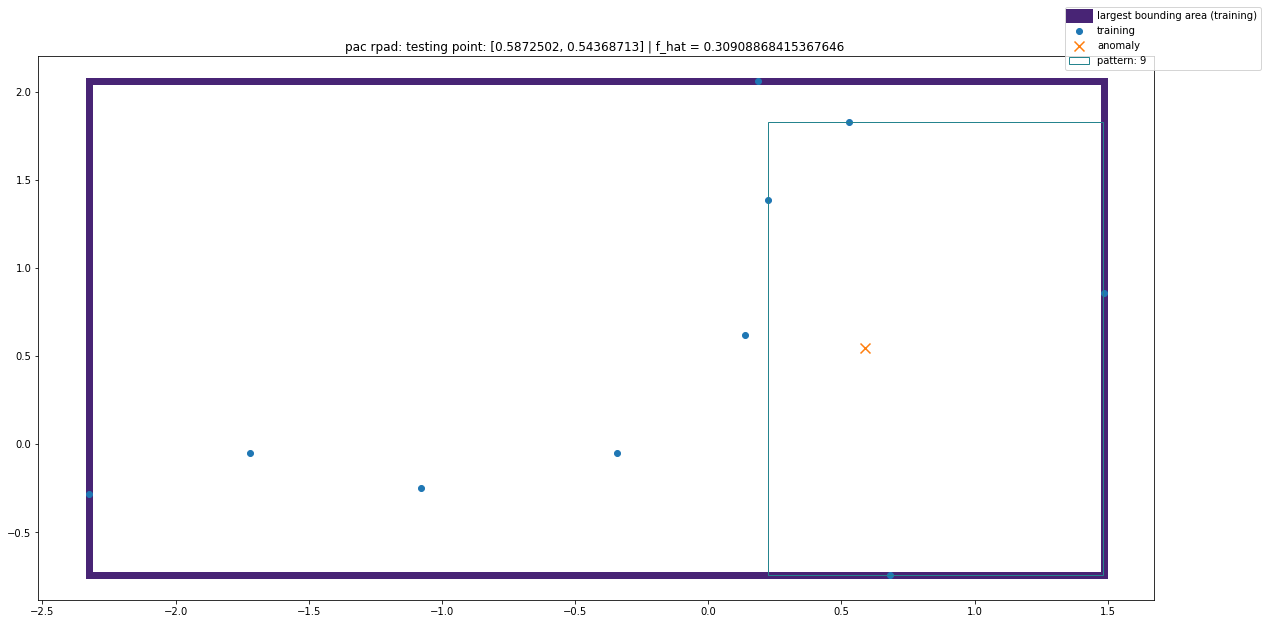

pattern:  None


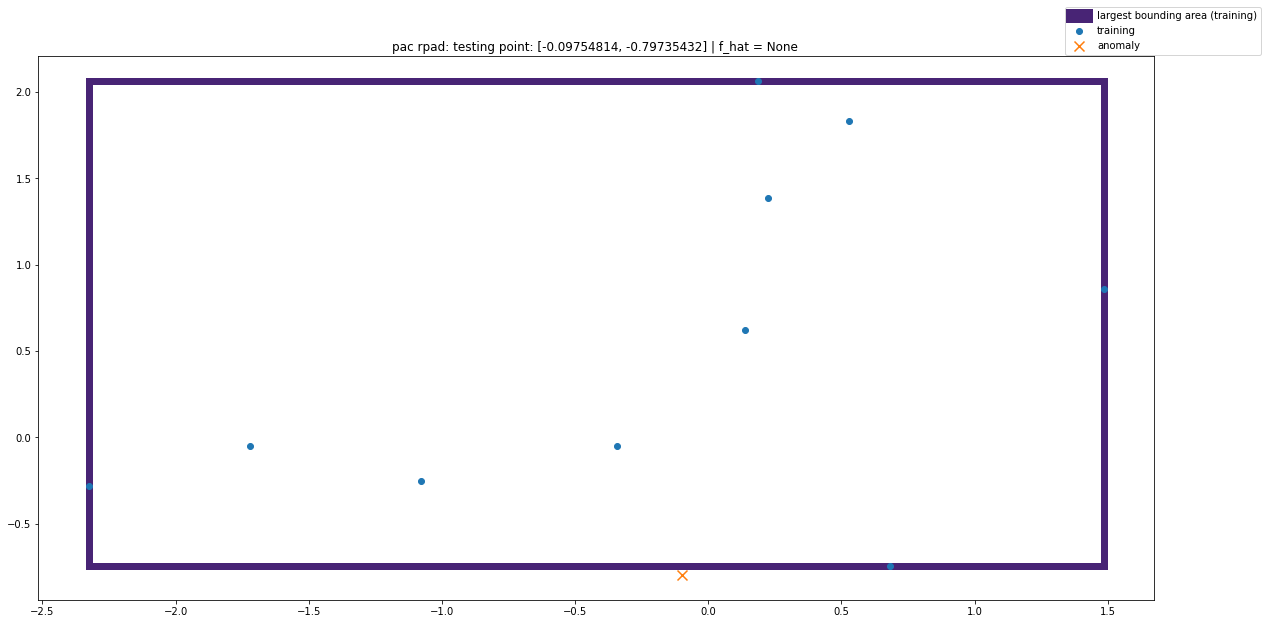

pattern:  [[-2.32450216  0.1355407 ]
 [-0.04661175  2.06290861]]


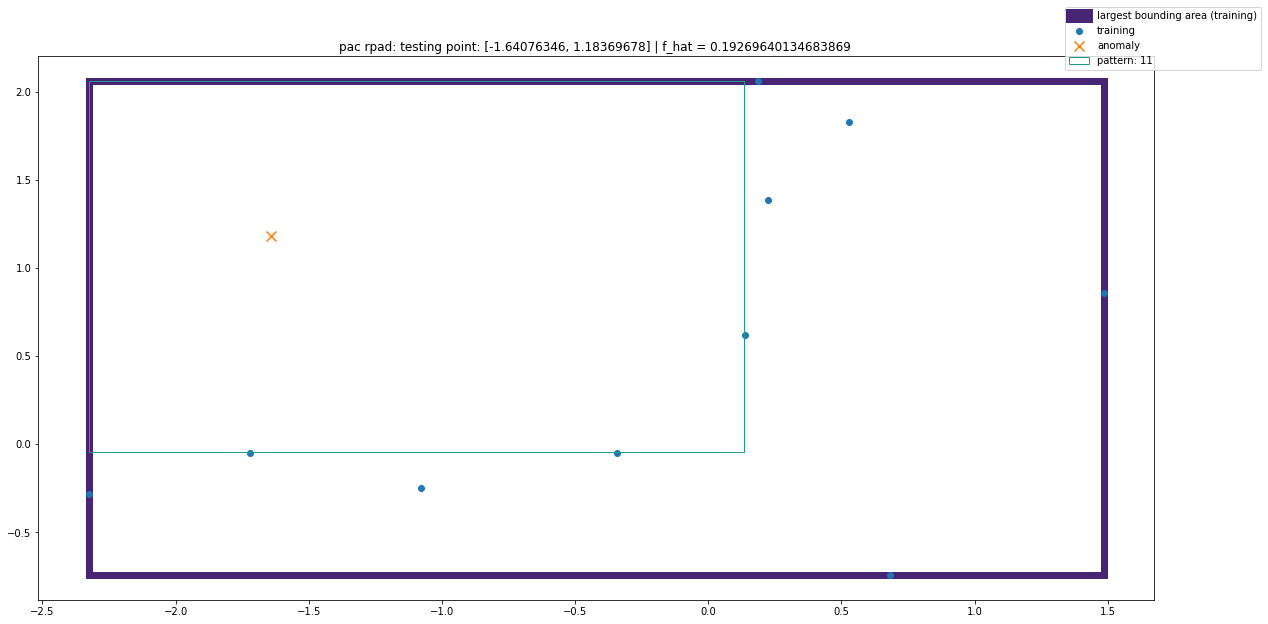

pattern:  [[-2.32350214  0.1355407 ]
 [-0.04661175  2.0619086 ]]


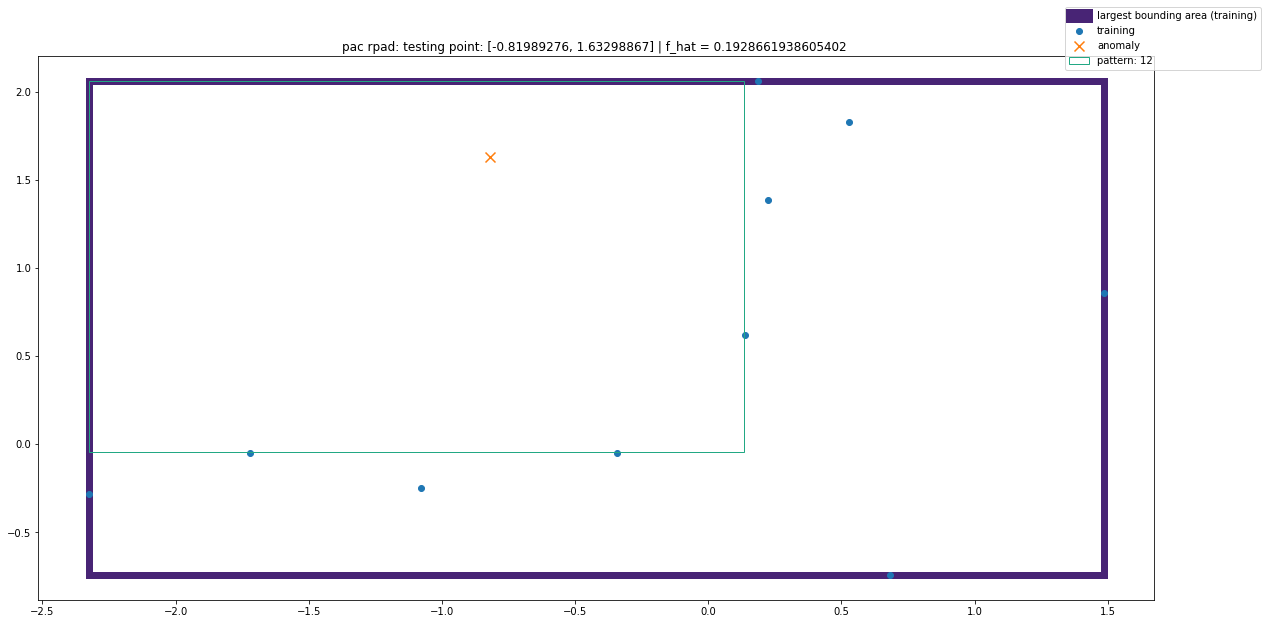

pattern:  None


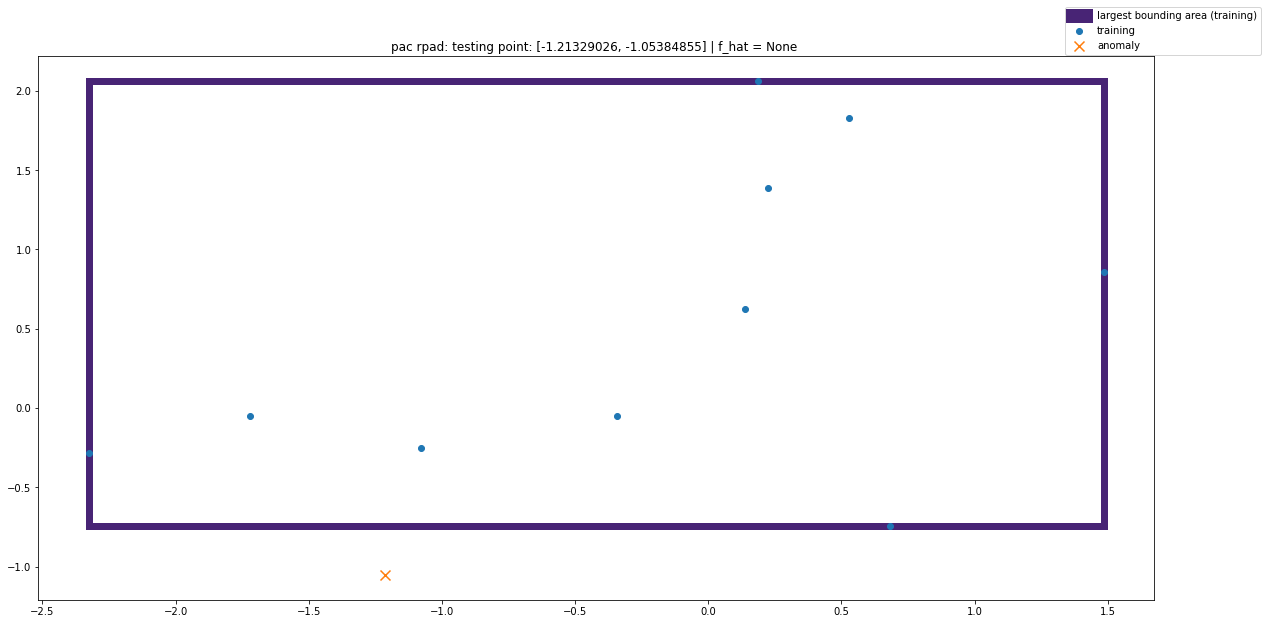

pattern:  None


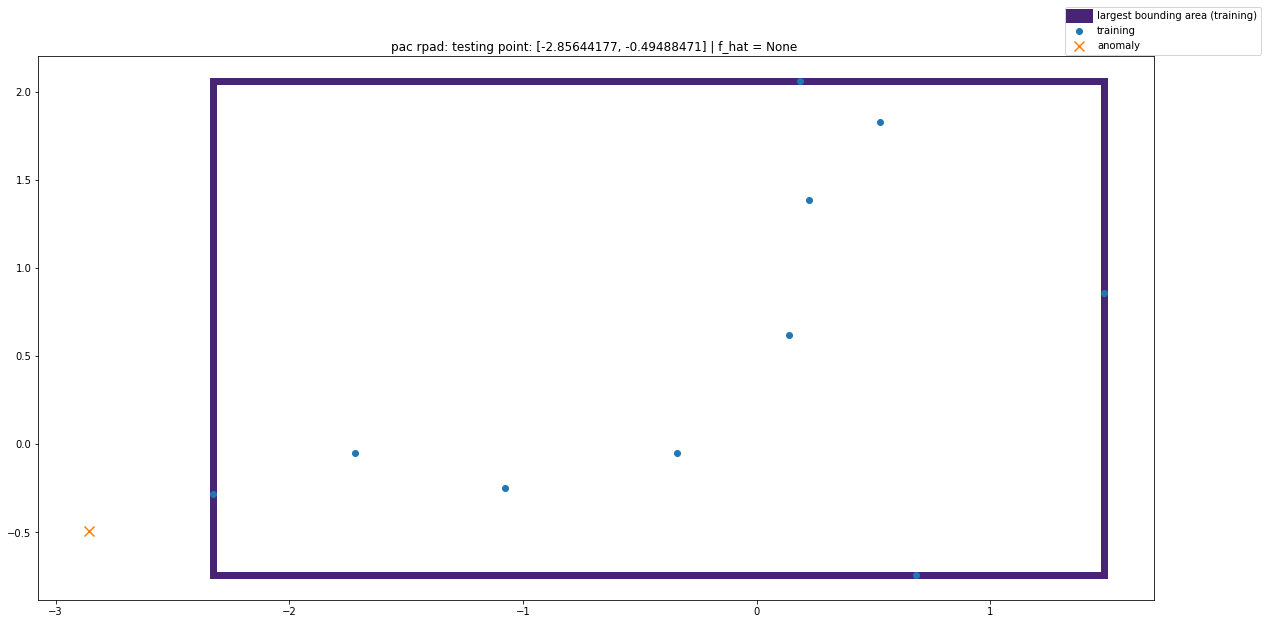

pattern:  [[-2.32350214  0.68051458]
 [-2.32450215 -0.05086057]]


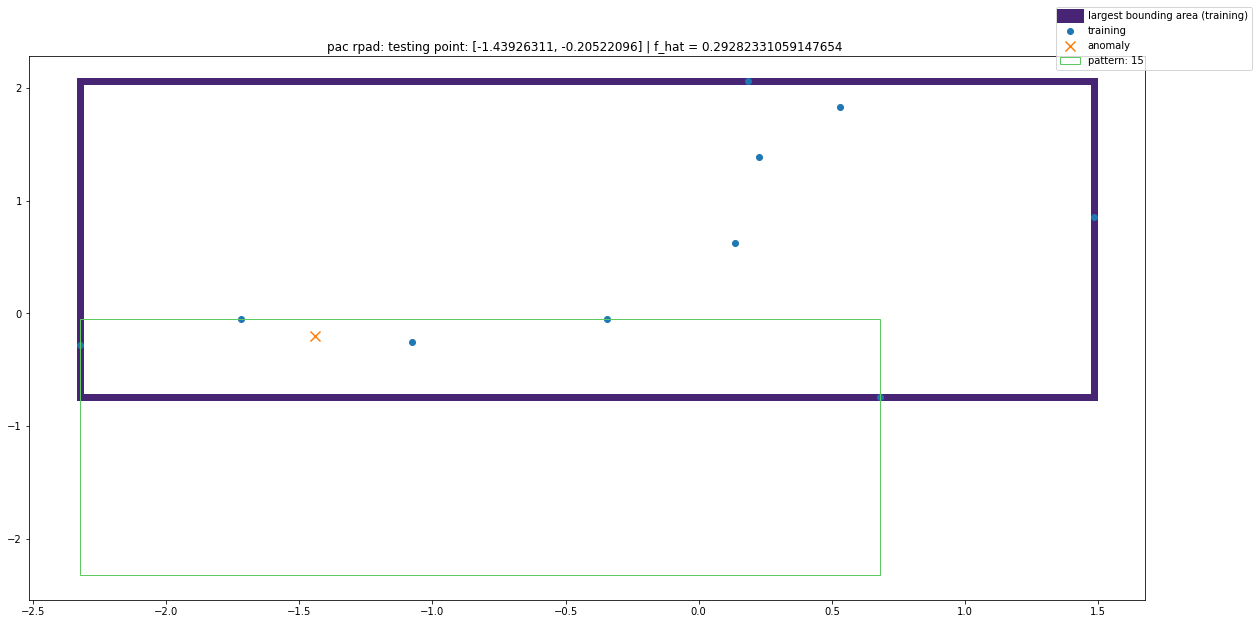

pattern:  [[-2.32350212  0.68051456]
 [-2.32450214 -0.25261948]]


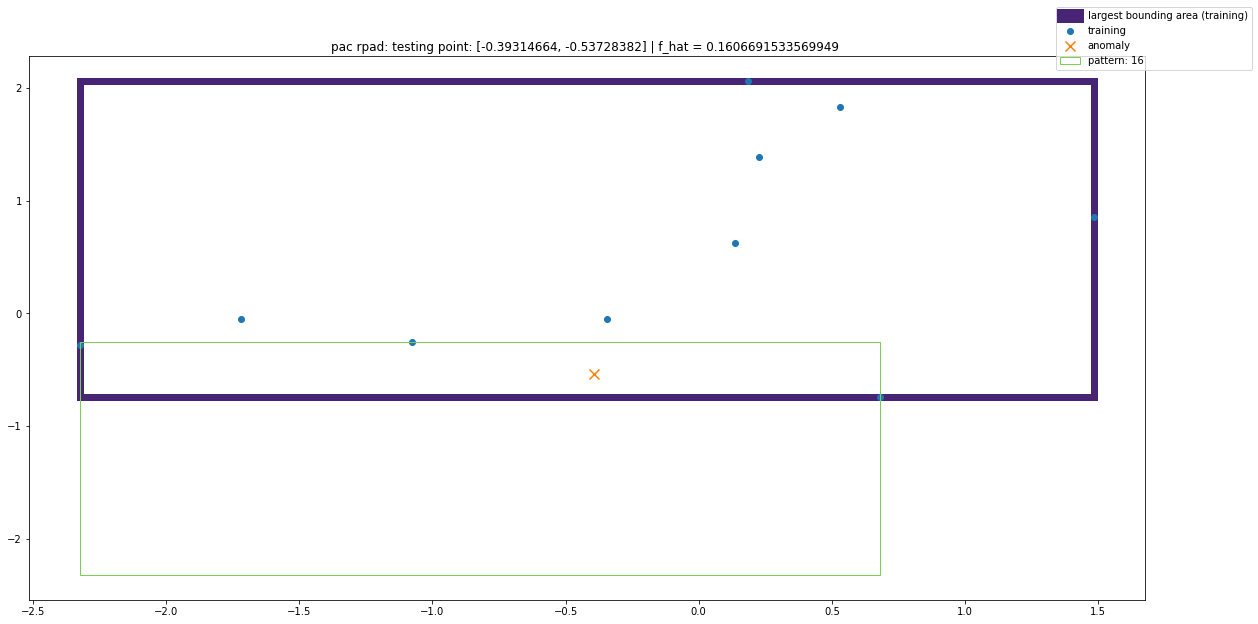

pattern:  None


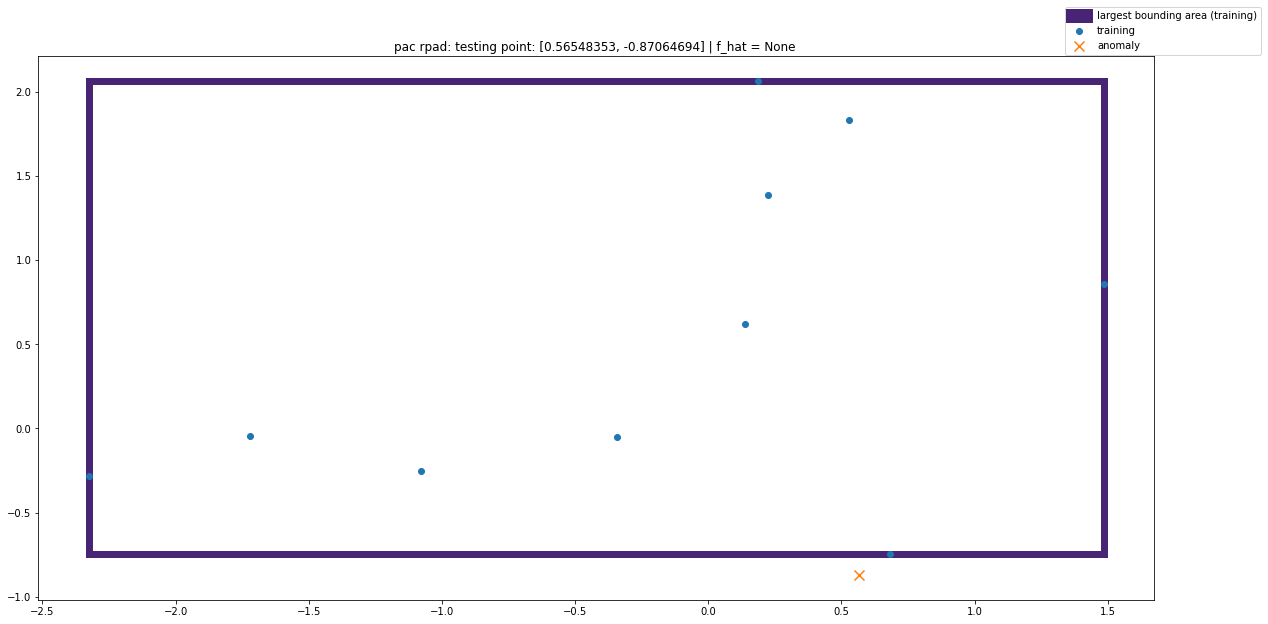

pattern:  [[-2.32350213  1.48500079]
 [-2.32450215 -0.25261947]]


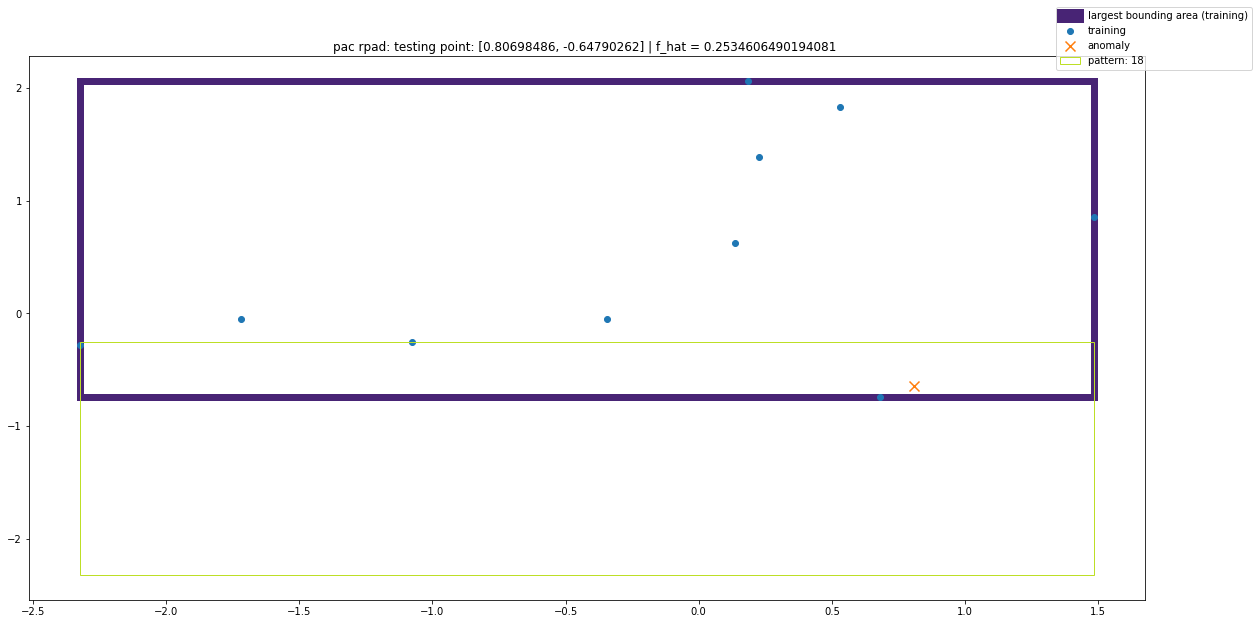

pattern:  [[-2.32450216  0.22376628]
 [ 0.62320881  2.06190861]]


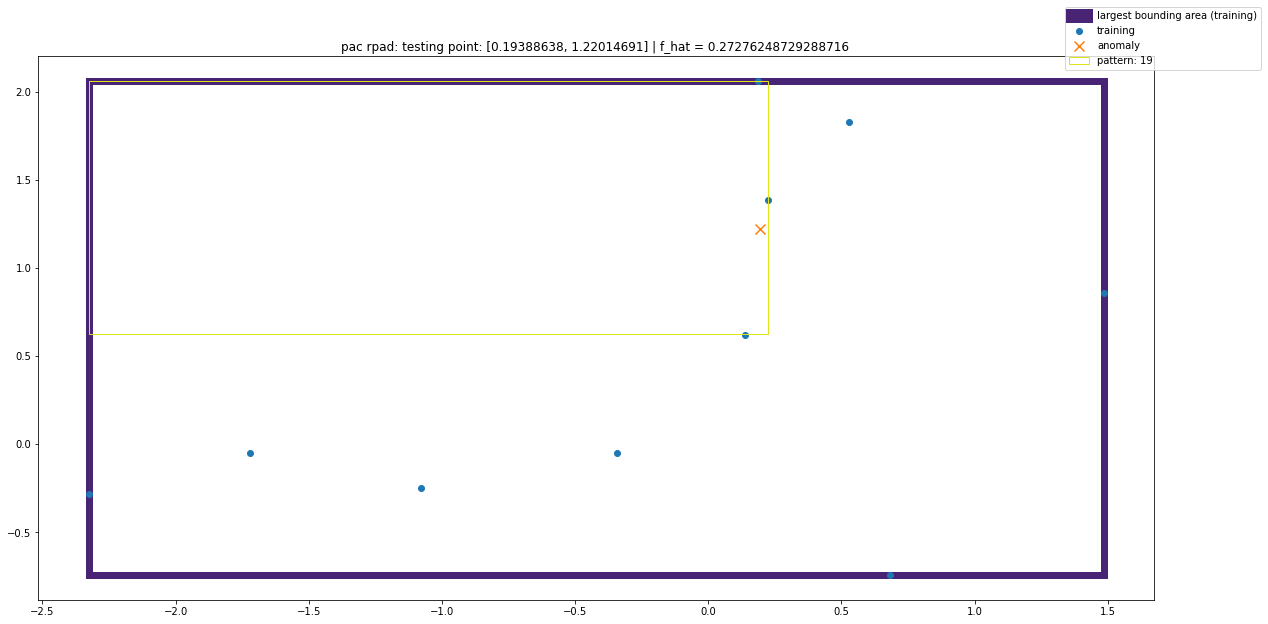

In [61]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)
cmap = plt.get_cmap('viridis')


def draw_largest_bounding_area(interval, ax):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(0.1),
        label= "largest bounding area (training)",
        linewidth=7.0
        )
    )


total = len(testing_points)
for i, (k,v) in enumerate(exact.find_min_f_hat.items()):
    ax = plt.gca()
    k = [float(x) for x in k[1:-1].split(" ") if x]
    point = k # exact.testing_points[i]
    draw_largest_bounding_area(exact.solver.largest_bounding_area.T, ax)
    ax.scatter(x=exact.training_points[:,0], y=exact.training_points[:,1], marker="o", label="training")
    pattern = np.array(v['pattern'])
    anomaly = v['anomaly']
    f_hat = v['objective']
    if anomaly:
        plt.scatter(x=k[0], y=k[1], marker="x", s=100, label="anomaly")
        print("pattern: ", pattern)
        if pattern.all() != None:
            draw2dpattern(pattern, ax, i, total)
    else:
        draw2dpattern(pattern, ax, i, total)
        ax.scatter(x=point[0], y=point[1], marker="x", s=150, label=f"testing point: {k}: normal")
    ax.legend(bbox_to_anchor=(1.1, 1.1))
    plt.title(f"pac rpad: testing point: {k} | f_hat = {f_hat} ")
    plt.show()


In [62]:
# TODO: TEST !!!
    # - implemenent simple test (4 points where the correct answer is already known)
    #   - find the correct pattern, respect the boundaries in each of the dim, use simplest training set and simplest test point 
    #   - training set: (0.0,0.0) (2.0,0.0) (0.0,2.0) (2.0,2.0)
    #   - testing point: (1.0,1.0) 
    #   - unit test to test the functionnalities of the functions 
        # run solver and compare with the expected result 
            # - for the pattern intervals 
            # - for the min area 
            # - for the largest_bounding_area
    
# - one important thing is to think about how to configure the min_area value depending on the dataset.
    # min area: fraction of the bounding area, makes it dependent on the number of training points!  